## Criacao de uma pasta para as tabelas

Sera criado uma pasta para armazenar as imagens

In [16]:
import os

#pasta tabelas
diretorio = "tabelas"
try:
    os.makedirs(diretorio)
    print(f"Pasta '{diretorio}' criada com sucesso.")
except FileExistsError:
    print(f"A pasta '{diretorio}' já existe.")

#pasta tabelas/vetores
vetores = f"{diretorio}/vetores"
try:
    os.makedirs(vetores)
    print(f"Pasta '{vetores}' criada com sucesso.")
except FileExistsError:
    print(f"A pasta '{vetores}' já existe.")


#pasta tabelas/notas_d
notas_d = f"{diretorio}/notas"
try:
    os.makedirs(notas_d)
    print(f"Pasta '{notas_d}' criada com sucesso.")
except FileExistsError:
    print(f"A pasta '{notas_d}' já existe.")

#pasta tabelas/questionario
questionario = f"{diretorio}/questionario"
try:
    os.makedirs(questionario)
    print(f"Pasta '{questionario}' criada com sucesso.")
except FileExistsError:
    print(f"A pasta '{questionario}' já existe.")    

#pasta tabelas/enade
enade = f"{diretorio}/enade"
try:
    os.makedirs(enade)
    print(f"Pasta '{enade}' criada com sucesso.")
except FileExistsError:
    print(f"A pasta '{enade}' já existe.")   

#pasta tabelas/percepcao_prova
percepcao_prova = f"{diretorio}/percepcao_prova"
try:
    os.makedirs(percepcao_prova)
    print(f"Pasta '{percepcao_prova}' criada com sucesso.")
except FileExistsError:
    print(f"A pasta '{percepcao_prova}' já existe.")  



A pasta 'tabelas' já existe.
A pasta 'tabelas/vetores' já existe.
A pasta 'tabelas/notas' já existe.
A pasta 'tabelas/questionario' já existe.
A pasta 'tabelas/enade' já existe.
A pasta 'tabelas/percepcao_prova' já existe.


### Funcao Grafico Barras Eixo X

In [17]:
### Funcao Grafico Barras Eixo X
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

def criar_mapeamento_co_ies_para_nome_ies(dir_entrada):
    df = pd.read_csv(dir_entrada, sep=';', usecols=['CO_IES', 'NOME_IES'])
    mapeamento = df.drop_duplicates().set_index('CO_IES')['NOME_IES'].to_dict()
    return mapeamento

def formatar_curso(course_name):
    return unidecode(course_name).lower()

def grafico_microdados_barras(dir_entrada, qe_column, faculdades_filtradas_CO_IES, cursos_analisados, dir_destino, titulo):
    df = pd.read_csv(dir_entrada, sep=';', usecols=['CO_IES', 'NOME_CURSO', qe_column])
    mapeamento_ies = criar_mapeamento_co_ies_para_nome_ies(dir_entrada)
    
    if faculdades_filtradas_CO_IES:
        df = df[df['CO_IES'].isin(faculdades_filtradas_CO_IES)]

    curso_map = df['NOME_CURSO'].dropna().unique()
    curso_map = {formatar_curso(curso): curso for curso in curso_map}
    df['NOME_CURSO_FORMATADO'] = df['NOME_CURSO'].apply(formatar_curso)
    cursos_analisados_formatados = [formatar_curso(curso) for curso in cursos_analisados]
    df_filtrado = df[df['NOME_CURSO_FORMATADO'].isin(cursos_analisados_formatados)]

    total_counts_per_course = df_filtrado[df_filtrado[qe_column].notna()].groupby('NOME_CURSO_FORMATADO')[qe_column].count()  
    

    plt.figure(figsize=(len(cursos_analisados)*10, 8))
    ax = sns.countplot(x='NOME_CURSO_FORMATADO', hue=qe_column, data=df_filtrado, palette='Set2', edgecolor='black', linewidth=1.2,
                       order=total_counts_per_course.index, width=0.9)
    

    max_count = df_filtrado.groupby('NOME_CURSO_FORMATADO')[qe_column].value_counts().max()

    ax.set_ylim(0, max_count*1.1)

    ax.set_xticklabels([curso_map[curso] for curso in total_counts_per_course.index], rotation=0, fontsize=14)
    nomes_ies = ', '.join([mapeamento_ies.get(co_ies, 'Desconhecida') for co_ies in faculdades_filtradas_CO_IES])
    plt.title(f"{titulo}\n{nomes_ies}", fontsize=16)
    plt.legend(title=qe_column, title_fontsize='13', fontsize='12')
    plt.xlabel('Curso',fontsize=15)
    plt.ylabel('Alunos',fontsize=15)

    handles, labels = ax.get_legend_handles_labels()
    legend_labels = []
    for handle, label in zip(handles, labels):
        count = df_filtrado[df_filtrado[qe_column] == label]['NOME_CURSO_FORMATADO'].value_counts()
        for course, course_count in count.iteritems():
            total = total_counts_per_course.get(course, 0)
            percentage = course_count / total * 100 if total > 0 else 0
            legend_labels.append(f"{label} ({percentage:.2f}%) - {course_count}")
    plt.legend(handles, legend_labels, title=qe_column, title_fontsize='13', fontsize='12')

    primeiro_curso, primeiro_total = next(iter(total_counts_per_course.items()))
    segundo_curso, segundo_total = None, None
    cursos_lista = list(total_counts_per_course.items())

    if len(cursos_lista) > 1:
        segundo_curso, segundo_total = cursos_lista[1]

    contador = 0

    for p in ax.patches:
        curso_label = ax.get_xticklabels()[int(p.get_x() + p.get_width() / 2.0)].get_text()
        curso_label_formatado = formatar_curso(curso_label)

        total_usado = primeiro_total if contador % 2 == 0 else segundo_total
        contador += 1

        if total_usado > 0:
            percentage = 100 * p.get_height() / total_usado
            annotation = f'{int(p.get_height())}\n({percentage:.2f}%)'
        else:
            annotation = f'{int(p.get_height())}\n(N/A)'

        ax.annotate(f"{annotation}", (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 18),
                    textcoords='offset points')
        
    plt.legend(title=qe_column, title_fontsize='13', fontsize='12')                    
    plt.savefig(dir_destino, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Funcao Grafico Barras Eixo Y

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

def grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada, qe_column, titulo):
    df = pd.read_csv(dir_entrada, sep=';', encoding='utf-8', low_memory=False)    
    mapeamento_ies = {co_ies: nome for co_ies, nome in zip(df['CO_IES'].unique(), df['NOME_IES'].unique())}

    
    if faculdades_filtradas_CO_IES:
        df_filtrado = df[df['CO_IES'].isin(faculdades_filtradas_CO_IES)].copy()
        nomes_ies = ', '.join(mapeamento_ies[co_ies] for co_ies in faculdades_filtradas_CO_IES if co_ies in mapeamento_ies)
    else:
        df_filtrado = df.copy()
        nomes_ies = ''

    cursos_analisados_formatados = [unidecode(curso).lower() for curso in cursos_analisados]

    df_filtrado['NOME_CURSO_FORMATADO'] = df_filtrado['NOME_CURSO'].apply(lambda x: unidecode(x).lower() if isinstance(x, str) else x)
    
    df_filtrado = df_filtrado[df_filtrado['NOME_CURSO_FORMATADO'].isin(cursos_analisados_formatados)]

    plt.figure(figsize=(6.5*len(cursos_analisados), 8))
    ax = sns.countplot(data=df_filtrado, y=qe_column, hue='NOME_CURSO', palette='Set2', edgecolor='black', linewidth=1.2)

    plt.xlabel('Alunos', fontsize=15)
    plt.ylabel('Respostas', fontsize=15)
    plt.legend(title='Curso', title_fontsize='13', fontsize='12')

    titulo = f"{titulo}\n{nomes_ies}" if nomes_ies else titulo
    plt.title(titulo, loc='center')

    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{int(width)}', (p.get_x() + width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=12, color='black', xytext=(5, 0),
                    textcoords='offset points')

    plt.tight_layout()
    plt.savefig(f'{questionario}/grafico_{qe_column}_h', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Funcao Grafico Circular

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from unidecode import unidecode
import numpy as np

def criar_mapeamento_co_ies_para_nome_ies(dir_entrada):
    df = pd.read_csv(dir_entrada, sep=';', usecols=['CO_IES', 'NOME_IES'])
    mapeamento = df.drop_duplicates().set_index('CO_IES')['NOME_IES'].to_dict()
    return mapeamento

def formatar_curso(course_name):
    return unidecode(course_name).lower()

def autopct_format(values):
    return lambda pct: ''

def grafico_microdados_circular(dir_entrada, qe_column, faculdades_filtradas_CO_IES, cursos_analisados, dir_destino, titulo):
    mapeamento_ies = criar_mapeamento_co_ies_para_nome_ies(dir_entrada)
    df = pd.read_csv(dir_entrada, sep=';', usecols=['CO_IES', 'NOME_CURSO', qe_column])
    mapeamento_ies = criar_mapeamento_co_ies_para_nome_ies(dir_entrada)
    if faculdades_filtradas_CO_IES:
        df = df[df['CO_IES'].isin(faculdades_filtradas_CO_IES)]

    curso_map = df['NOME_CURSO'].dropna().unique()
    curso_map = {formatar_curso(curso): curso for curso in curso_map}

    df['NOME_CURSO_FORMATADO'] = df['NOME_CURSO'].apply(formatar_curso)

    cursos_analisados_formatados = [formatar_curso(curso) for curso in cursos_analisados]
    df_filtrado = df[df['NOME_CURSO_FORMATADO'].isin(cursos_analisados_formatados)]

    df_grouped = df_filtrado.groupby('NOME_CURSO_FORMATADO')[qe_column].value_counts().unstack(fill_value=0)
    df_grouped = df_grouped.reindex(cursos_analisados_formatados)

    colors = cm.Set3.colors

    for curso in cursos_analisados_formatados:
        counts = df_grouped.loc[curso]
        total = counts.sum()
        sorted_counts = counts.sort_values(ascending=False)

        legend_labels = [f"{label} ({count / total * 100:.2f}%) - {count}" for label, count in sorted_counts.items()]

        fig, ax = plt.subplots(figsize=(12, 8))
        wedges, texts, autotexts = ax.pie(sorted_counts, autopct=autopct_format(sorted_counts),
                                          startangle=90, colors=colors,
                                          shadow=True, wedgeprops=dict(width=0.3, edgecolor='gray'))

        ax.legend(wedges, legend_labels, title=f"Porcentagem e Número de alunos {qe_column}", loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

        nomes_ies = ', '.join([mapeamento_ies.get(co_ies, 'Desconhecida') for co_ies in faculdades_filtradas_CO_IES])
        plt.title(f"{titulo}\n{nomes_ies}\n{curso_map[curso]}", fontsize=16)
        plt.savefig(f"{dir_destino}_{curso}.png", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

### Funcao Heatmap de todos os cursos


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def heatmap_todos_cursos(dir_entrada, qe_column, titulo):
    df = pd.read_csv(dir_entrada, sep=';', usecols=['NOME_CURSO', qe_column])

    tabela_contagem = df.groupby(['NOME_CURSO', qe_column]).size().unstack(fill_value=0)
    tabela_porcentagem = tabela_contagem.div(tabela_contagem.sum(axis=1), axis=0) * 100

    cmap = LinearSegmentedColormap.from_list('meu_colormap', ['white', 'lightblue', 'navy'])
    
    #tamanho do gráfico
    plt.figure(figsize=(15, 8))
    #plt.figure(figsize=(45, 8))
    
    annot_values = tabela_contagem.astype(str) + " - (" + tabela_porcentagem.round(1).astype(str) + "%)"
    sns.heatmap(tabela_porcentagem, annot=annot_values, fmt="", cmap=cmap)
    
    plt.ylabel('Curso')
    plt.xlabel('Resposta')
    plt.title(titulo)
    
    nome_arquivo_saida = f'{enade}/heatmap_{qe_column}'
    plt.savefig(nome_arquivo_saida, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Heatmap salvo no diretório '{nome_arquivo_saida}'")


## Analisis questoes assertivas

### Entrada de dados analisados(Microdados)

In [21]:

#lista de cursos para a analise
cursos_analisados = ['ciencia Da Computacao (bacharelado)','ciencia da computacao (licenciatura)' ]
#codigo ies para a faculdade analisada
faculdades_filtradas_CO_IES=[2]
dir_entrada_dis = 'microdados_tratados/form_microdados_arq4.csv'


### Analisis questoes assertivas

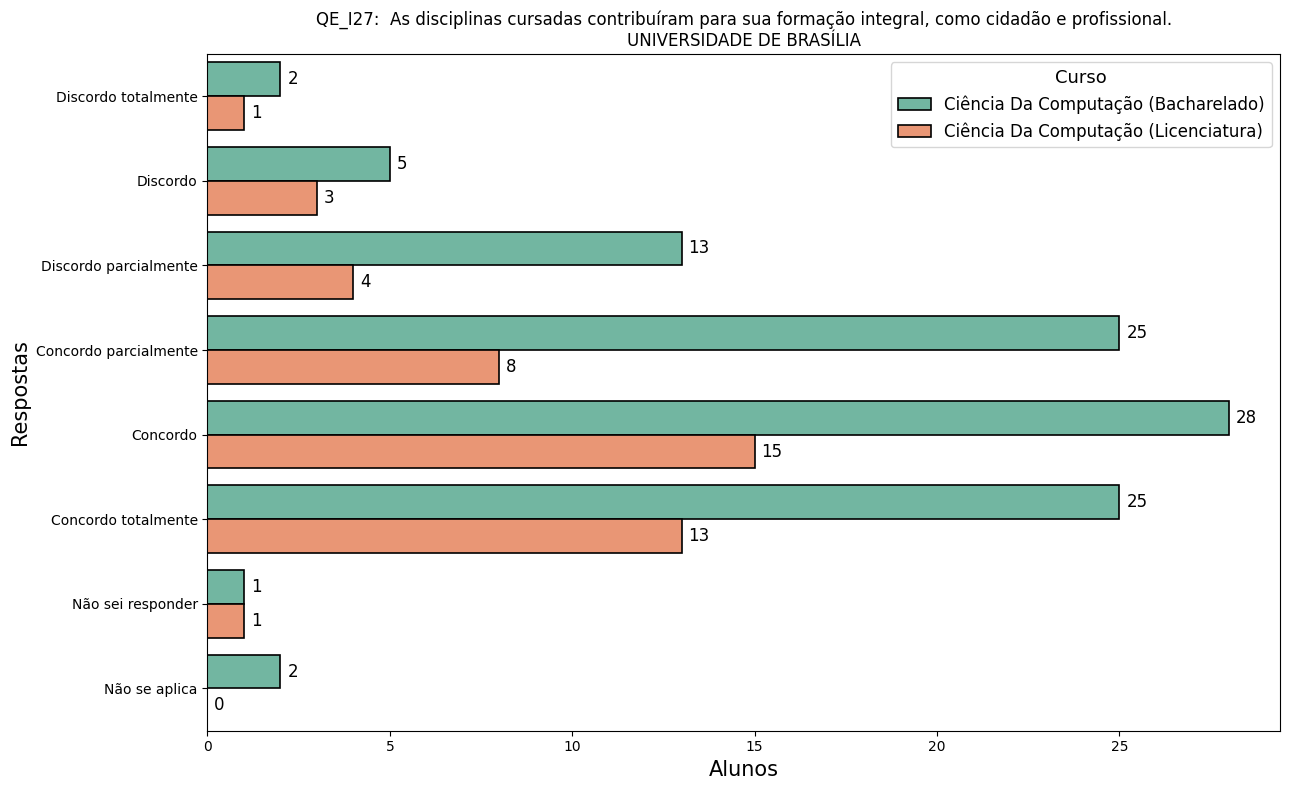

In [ ]:

dir_entrada_dis = 'microdados_tratados/form_microdados_arq4.csv'
qe_column = 'QE_I27'

titulo = f"{qe_column}:  As disciplinas cursadas contribuíram para sua formação integral, como cidadão e profissional."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)
#grafico_microdados_circular(dir_entrada, qe_column, faculdades_filtradas_CO_IES, cursos_analisados, dir_destino, titulo)

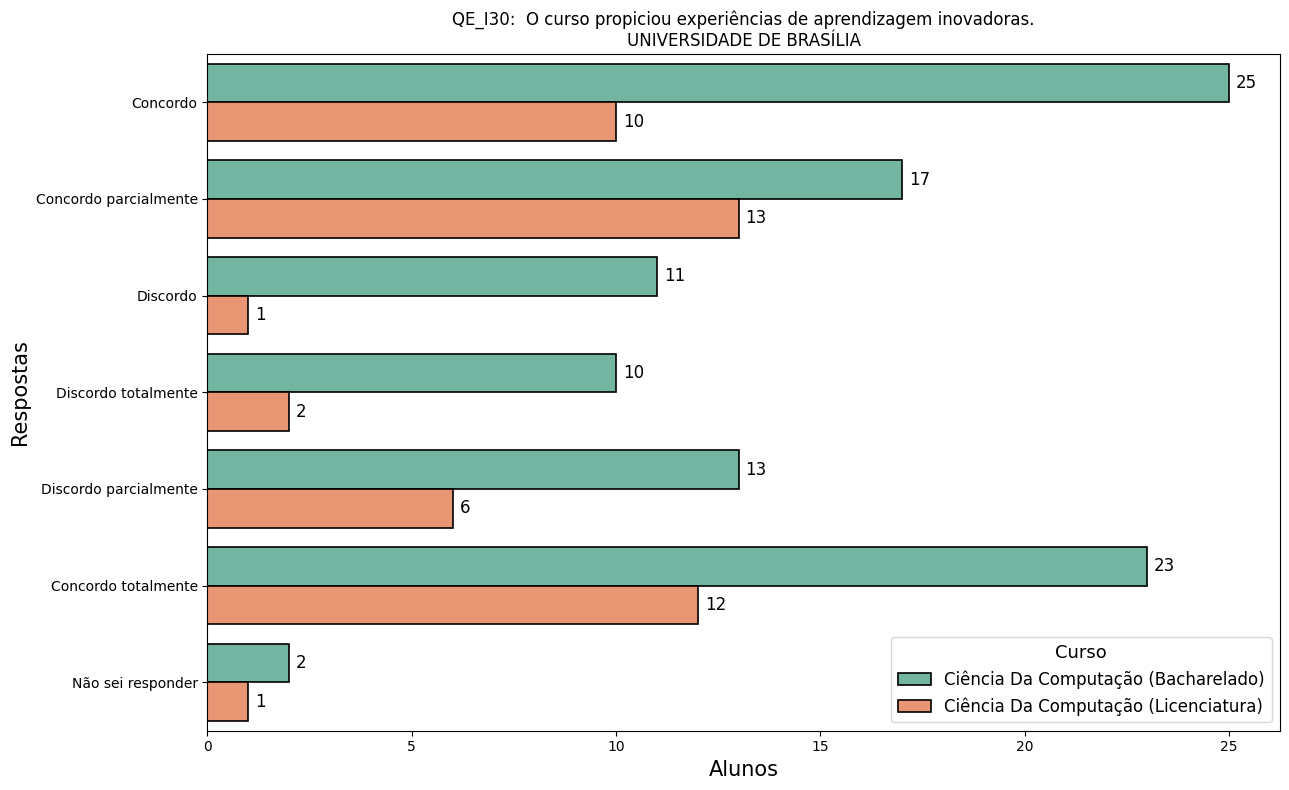

In [ ]:
qe_column = 'QE_I30'
titulo = f"{qe_column}:  O curso propiciou experiências de aprendizagem inovadoras."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


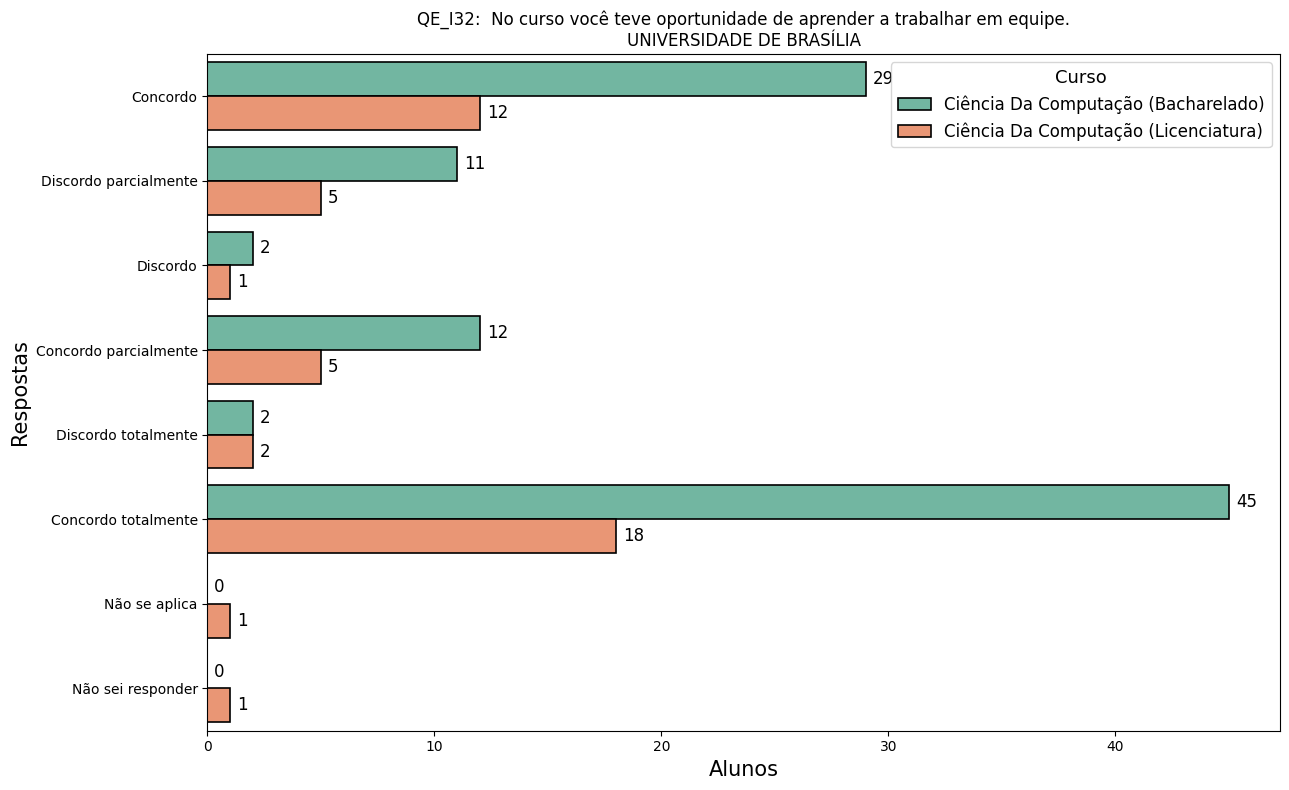

In [ ]:
qe_column = 'QE_I32'
titulo = f"{qe_column}:  No curso você teve oportunidade de aprender a trabalhar em equipe."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


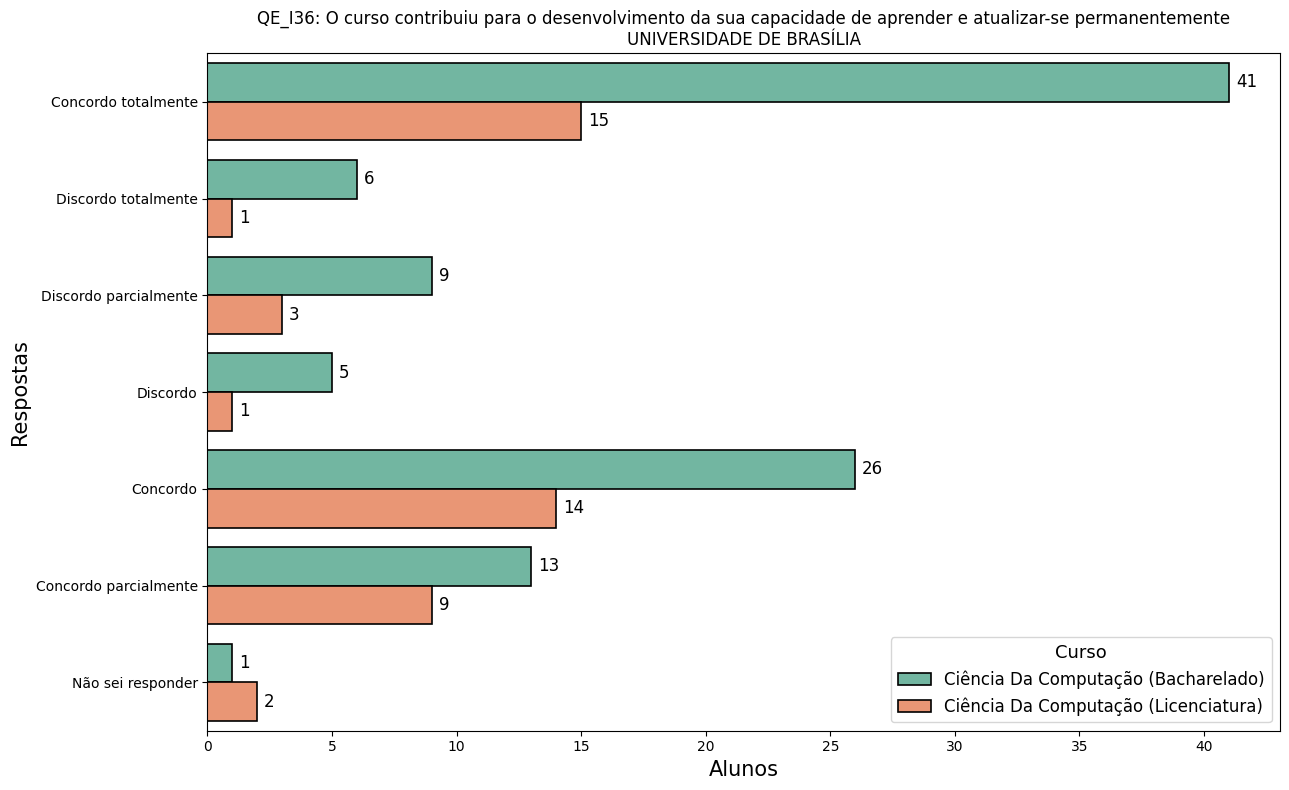

In [ ]:
qe_column = 'QE_I36'
titulo = f"{qe_column}: O curso contribuiu para o desenvolvimento da sua capacidade de aprender e atualizar-se permanentemente"

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


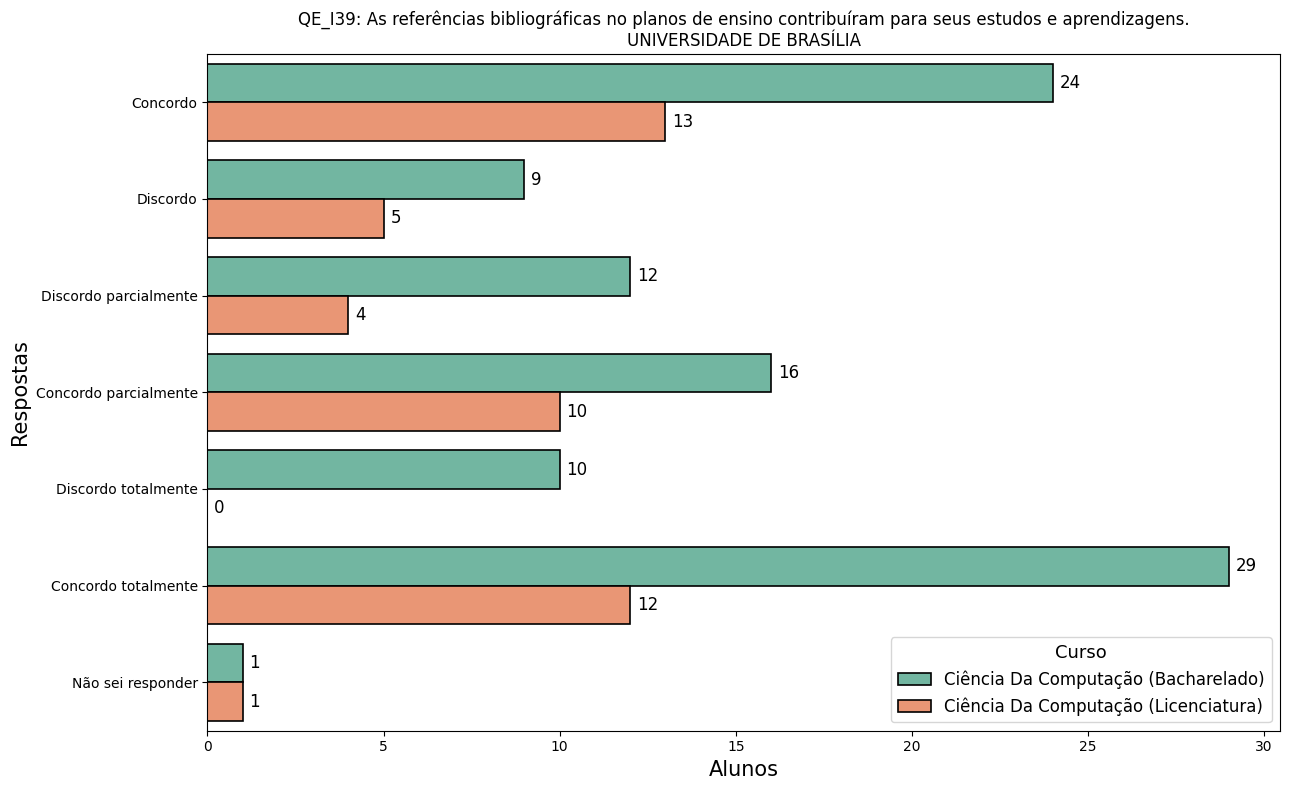

In [ ]:
qe_column = 'QE_I39'
titulo = f"{qe_column}: As referências bibliográficas no planos de ensino contribuíram para seus estudos e aprendizagens."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


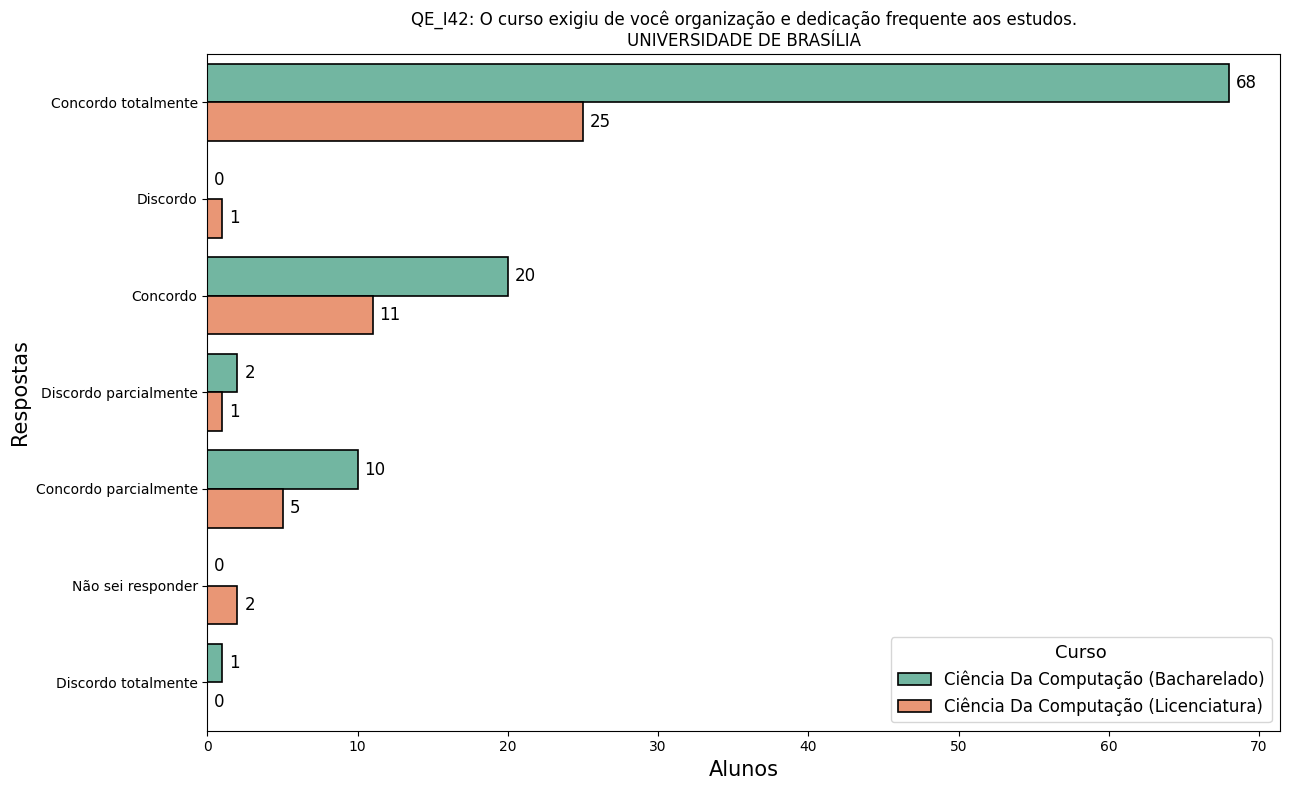

In [ ]:
qe_column = 'QE_I42'
titulo = f"{qe_column}: O curso exigiu de você organização e dedicação frequente aos estudos."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


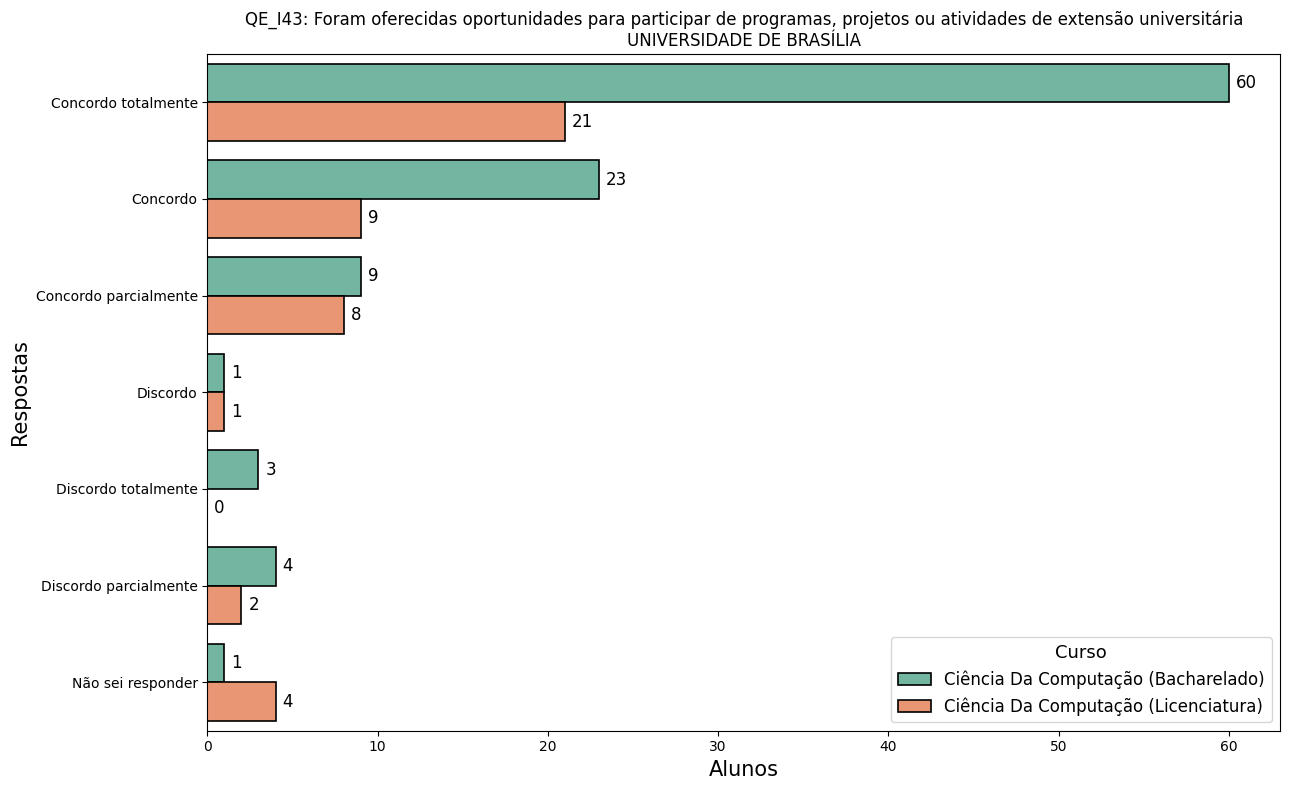

In [ ]:
qe_column = 'QE_I43'
titulo = f"{qe_column}: Foram oferecidas oportunidades para participar de programas, projetos ou atividades de extensão universitária"

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


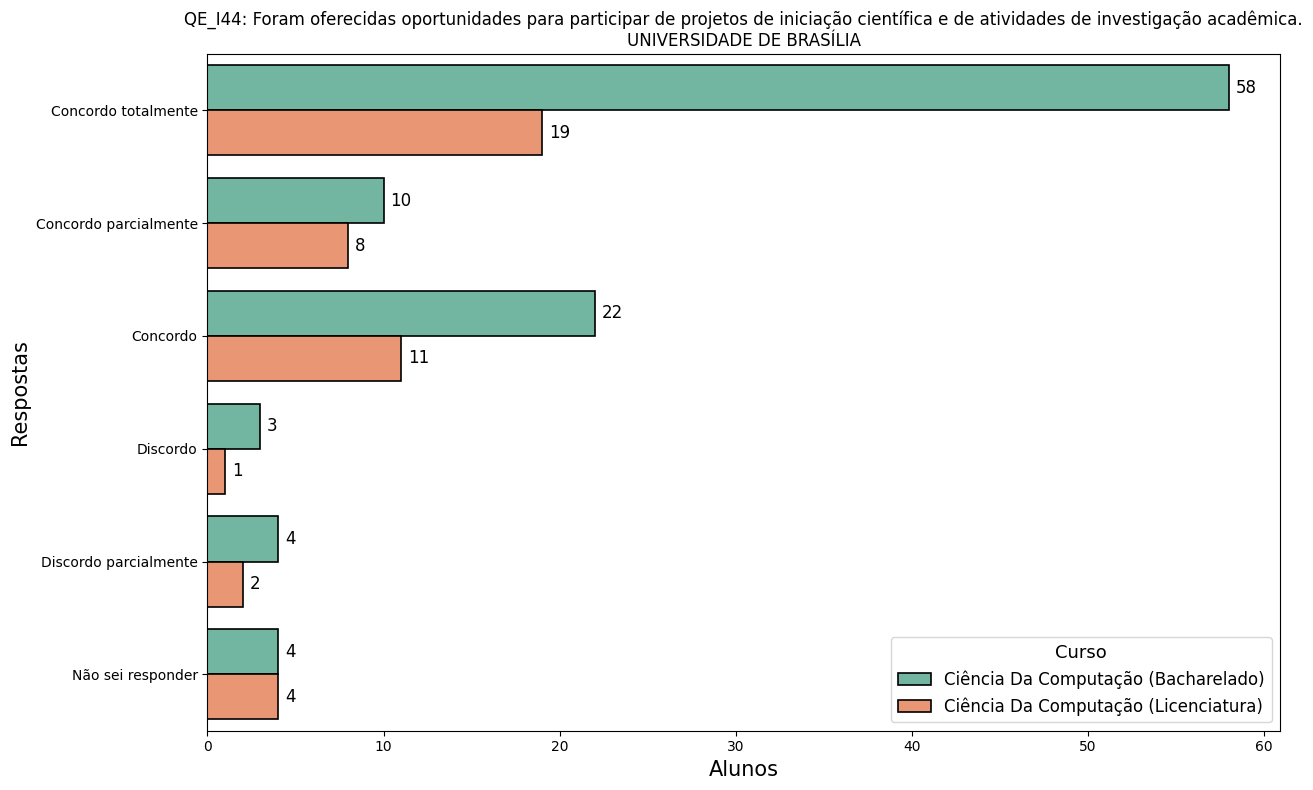

In [ ]:
qe_column = 'QE_I44'
titulo = f"{qe_column}: Foram oferecidas oportunidades para participar de projetos de iniciação científica e de atividades de investigação acadêmica."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


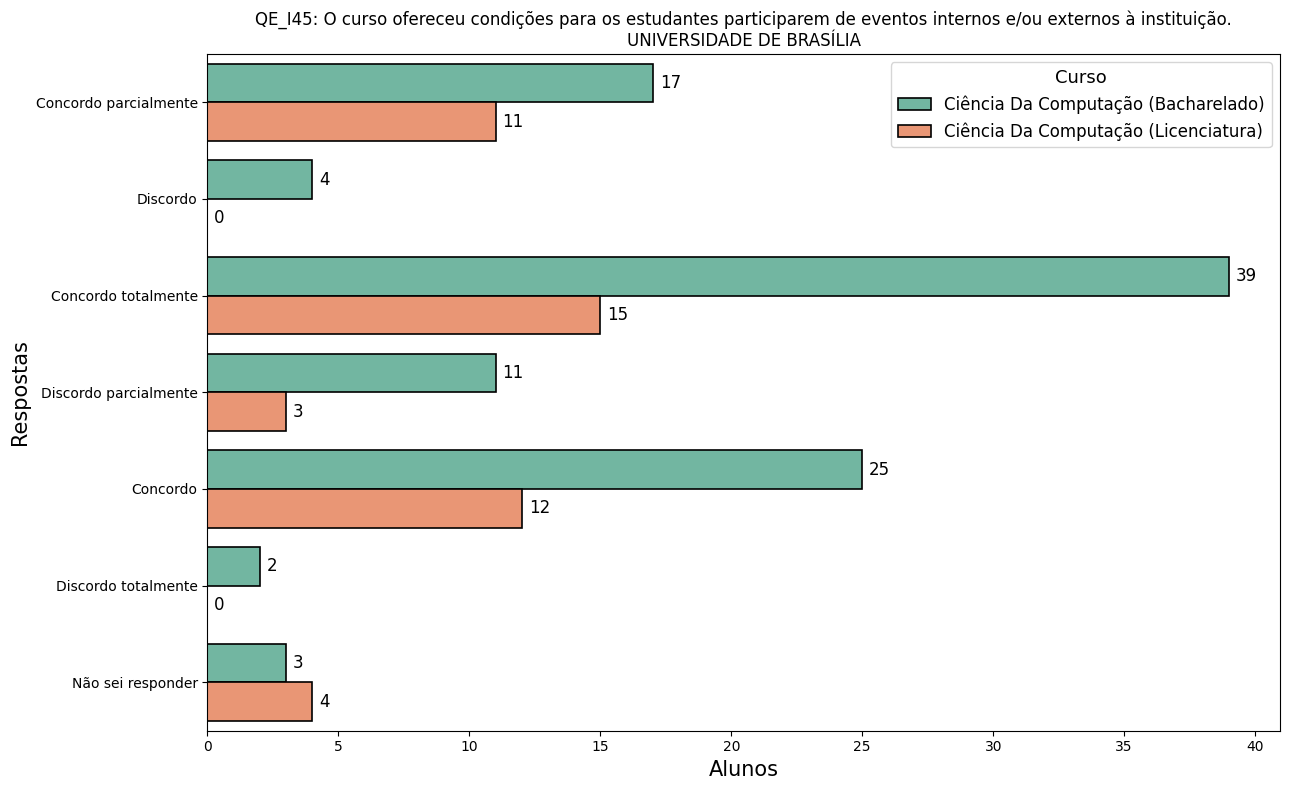

In [ ]:
qe_column = 'QE_I45'
titulo = f"{qe_column}: O curso ofereceu condições para os estudantes participarem de eventos internos e/ou externos à instituição."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


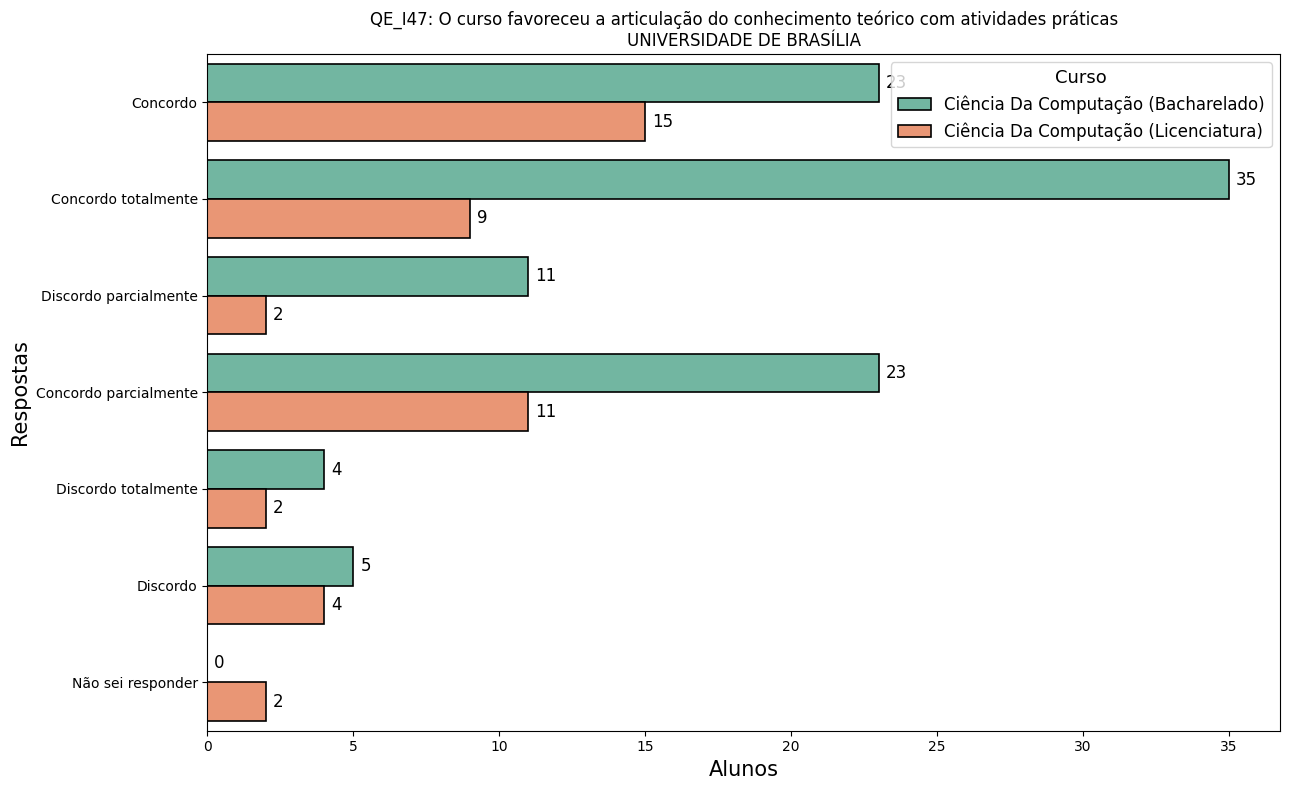

In [ ]:
qe_column = 'QE_I47'
titulo = f"{qe_column}: O curso favoreceu a articulação do conhecimento teórico com atividades práticas"

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


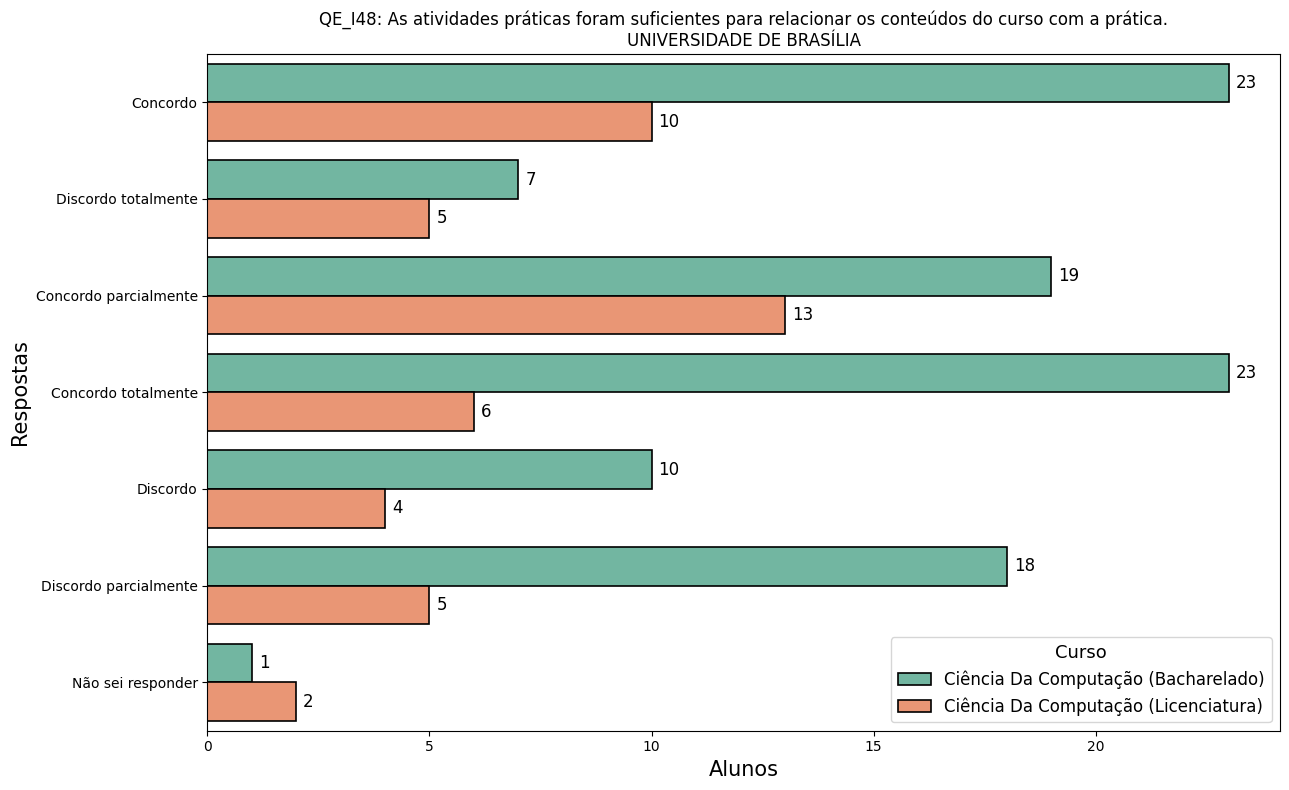

In [ ]:
qe_column = 'QE_I48'
titulo = f"{qe_column}: As atividades práticas foram suficientes para relacionar os conteúdos do curso com a prática."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


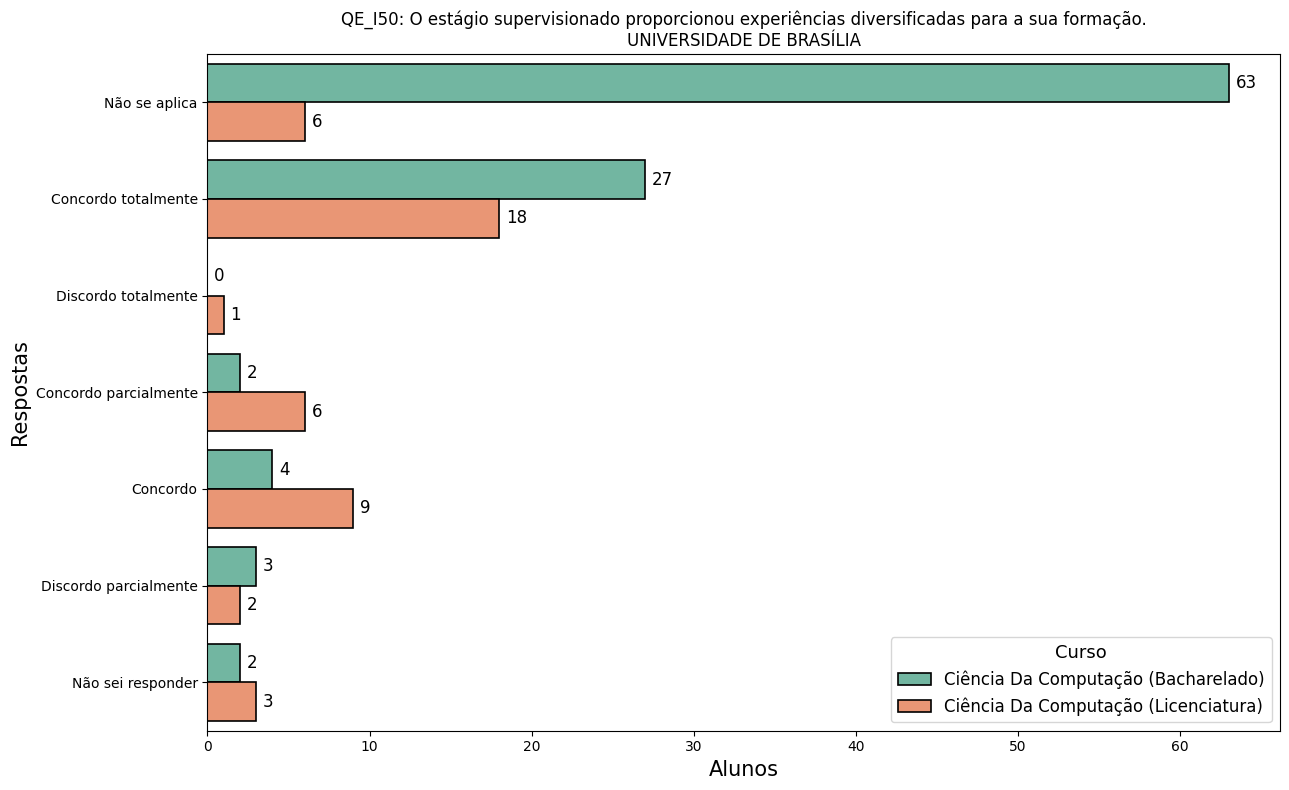

In [ ]:
qe_column = 'QE_I50'
titulo = f"{qe_column}: O estágio supervisionado proporcionou experiências diversificadas para a sua formação."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


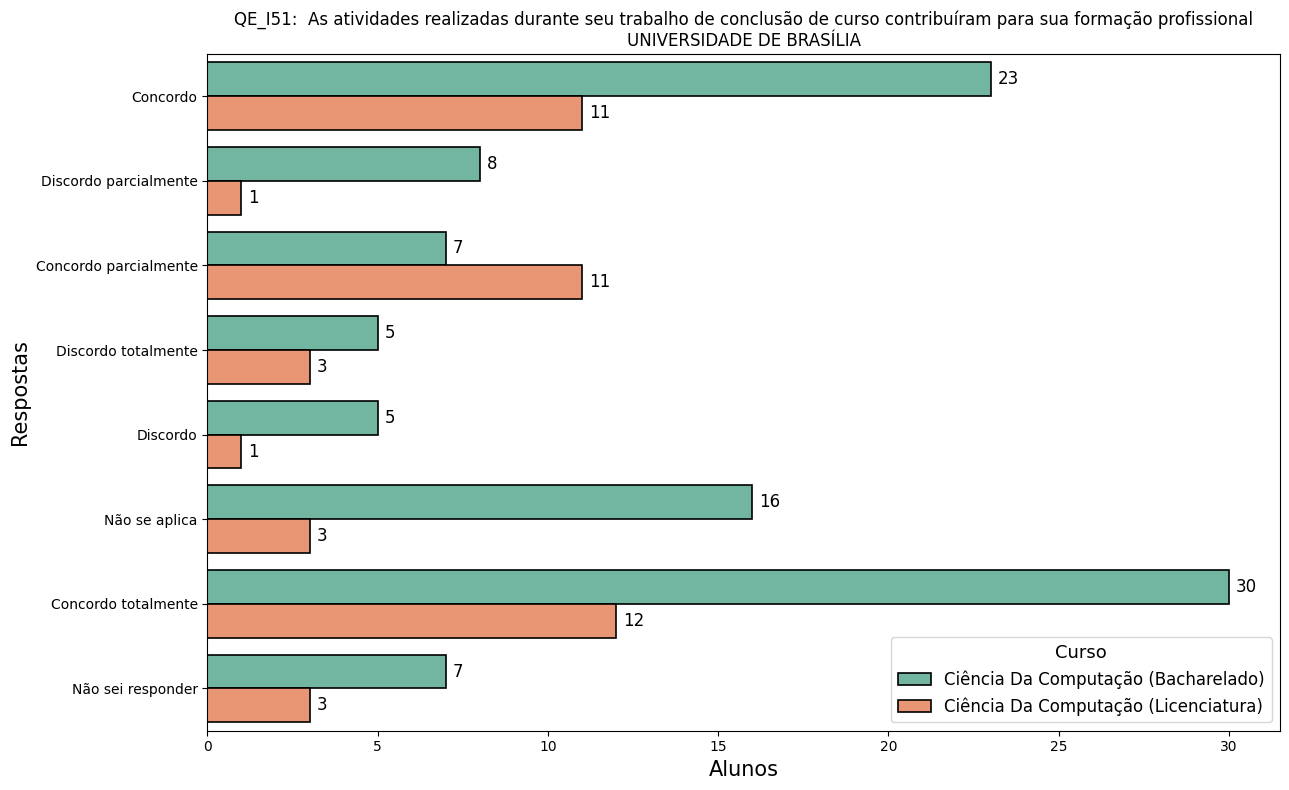

In [ ]:
qe_column = 'QE_I51'
titulo = f"{qe_column}:  As atividades realizadas durante seu trabalho de conclusão de curso contribuíram para sua formação profissional"

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


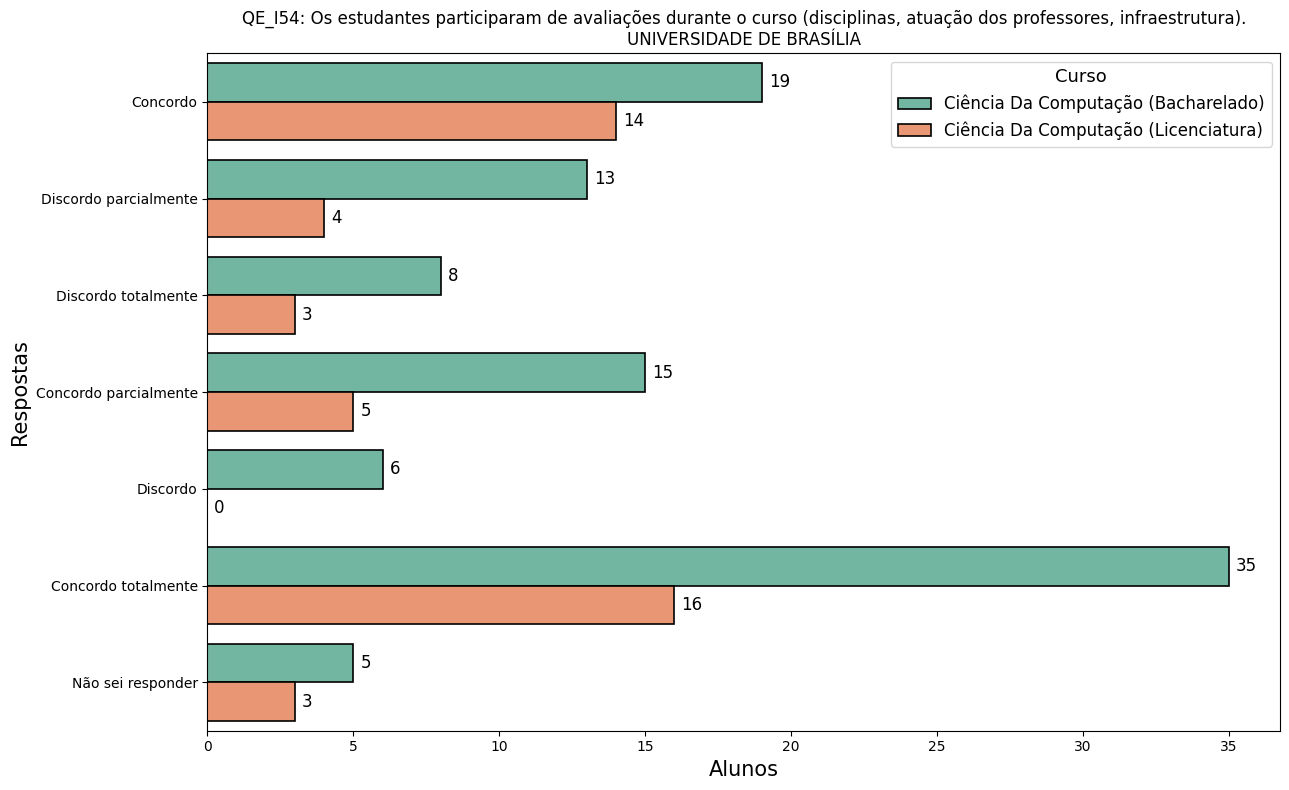

In [ ]:
qe_column = 'QE_I54'
titulo = f"{qe_column}: Os estudantes participaram de avaliações durante o curso (disciplinas, atuação dos professores, infraestrutura)."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


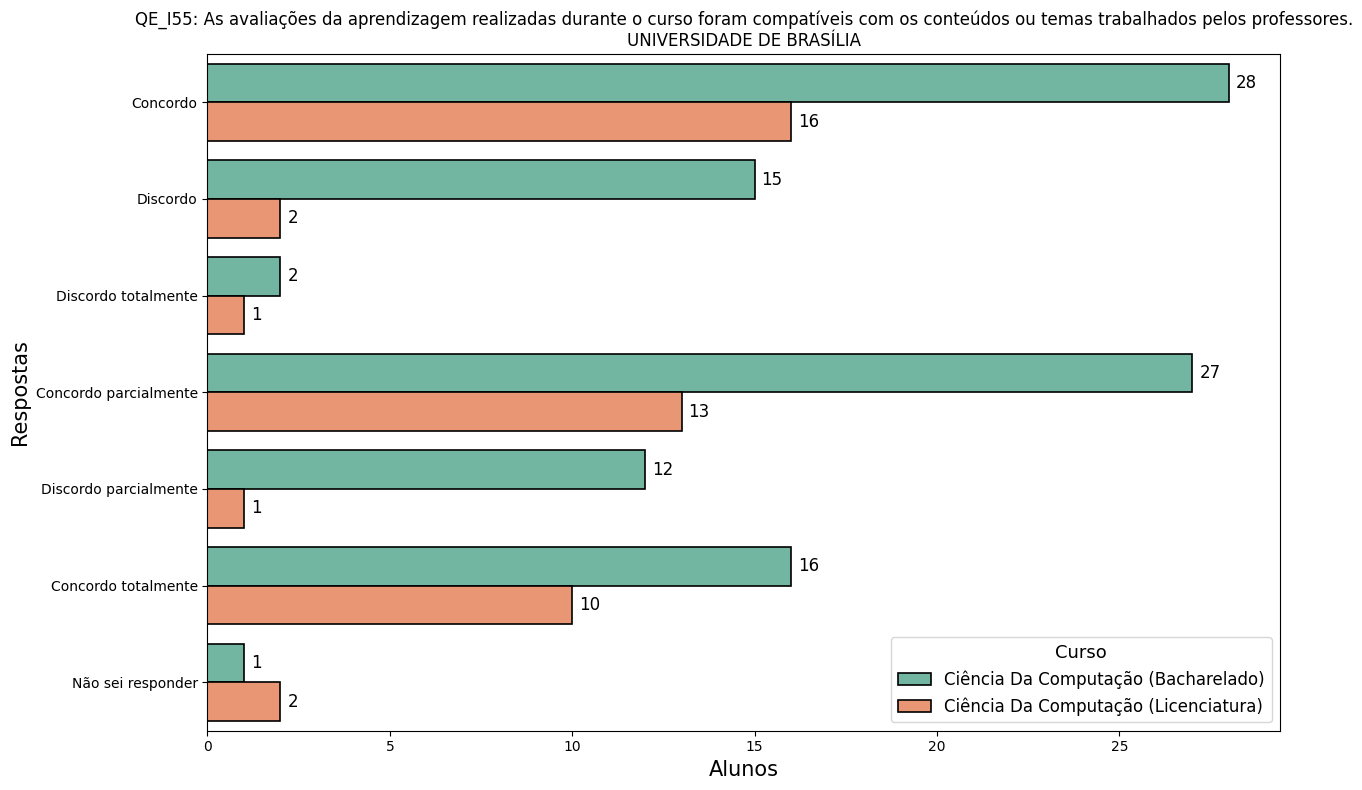

In [ ]:
qe_column = 'QE_I55'
titulo = f"{qe_column}: As avaliações da aprendizagem realizadas durante o curso foram compatíveis com os conteúdos ou temas trabalhados pelos professores."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


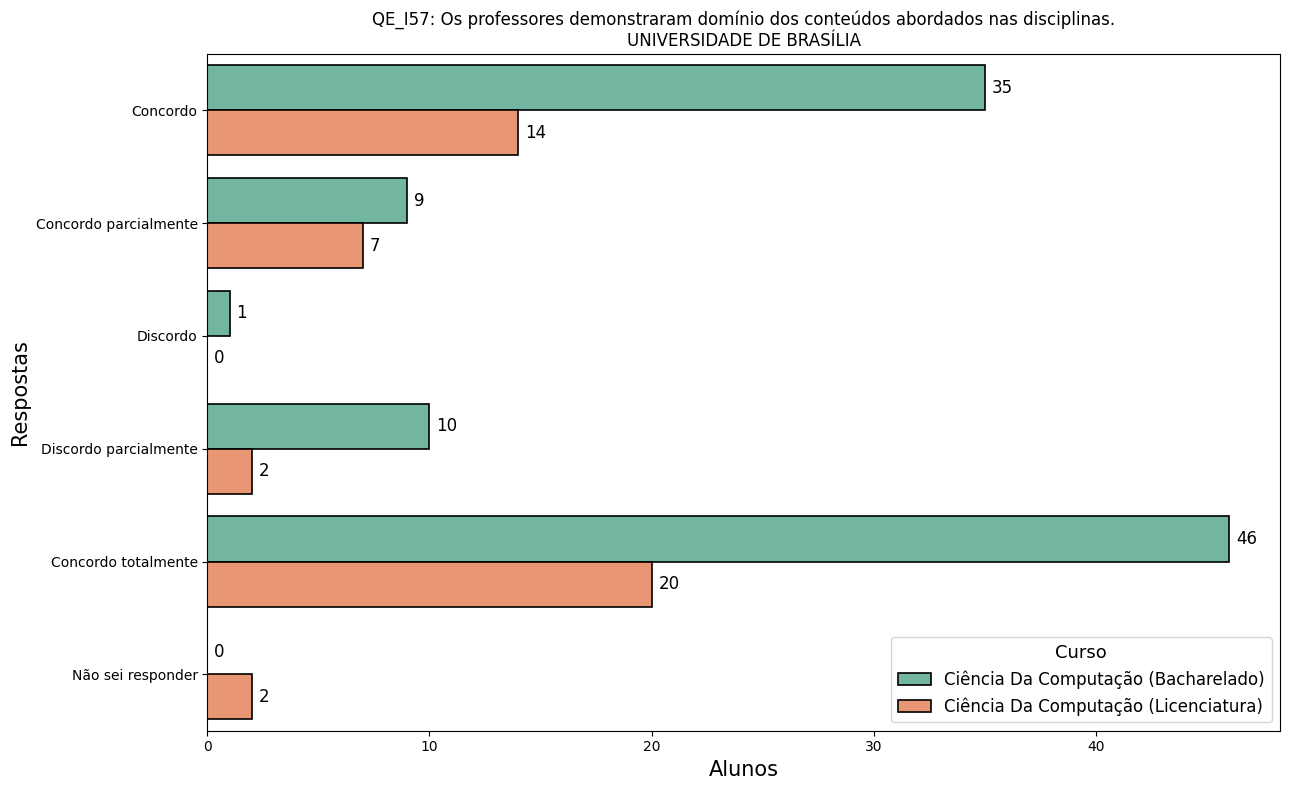

In [ ]:
qe_column = 'QE_I57'
titulo = f"{qe_column}: Os professores demonstraram domínio dos conteúdos abordados nas disciplinas."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


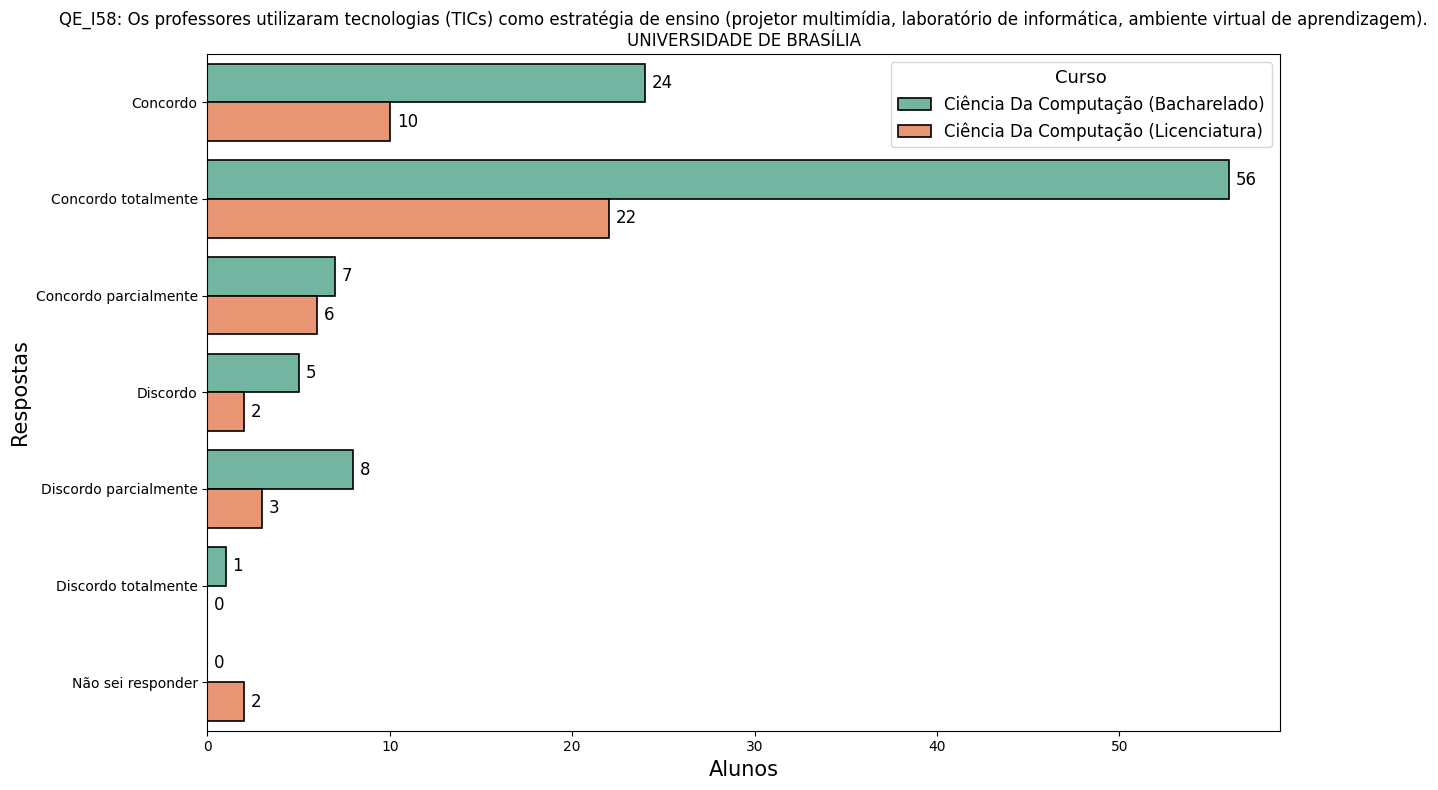

In [ ]:
qe_column = 'QE_I58'
titulo = f"{qe_column}: Os professores utilizaram tecnologias (TICs) como estratégia de ensino (projetor multimídia, laboratório de informática, ambiente virtual de aprendizagem)."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


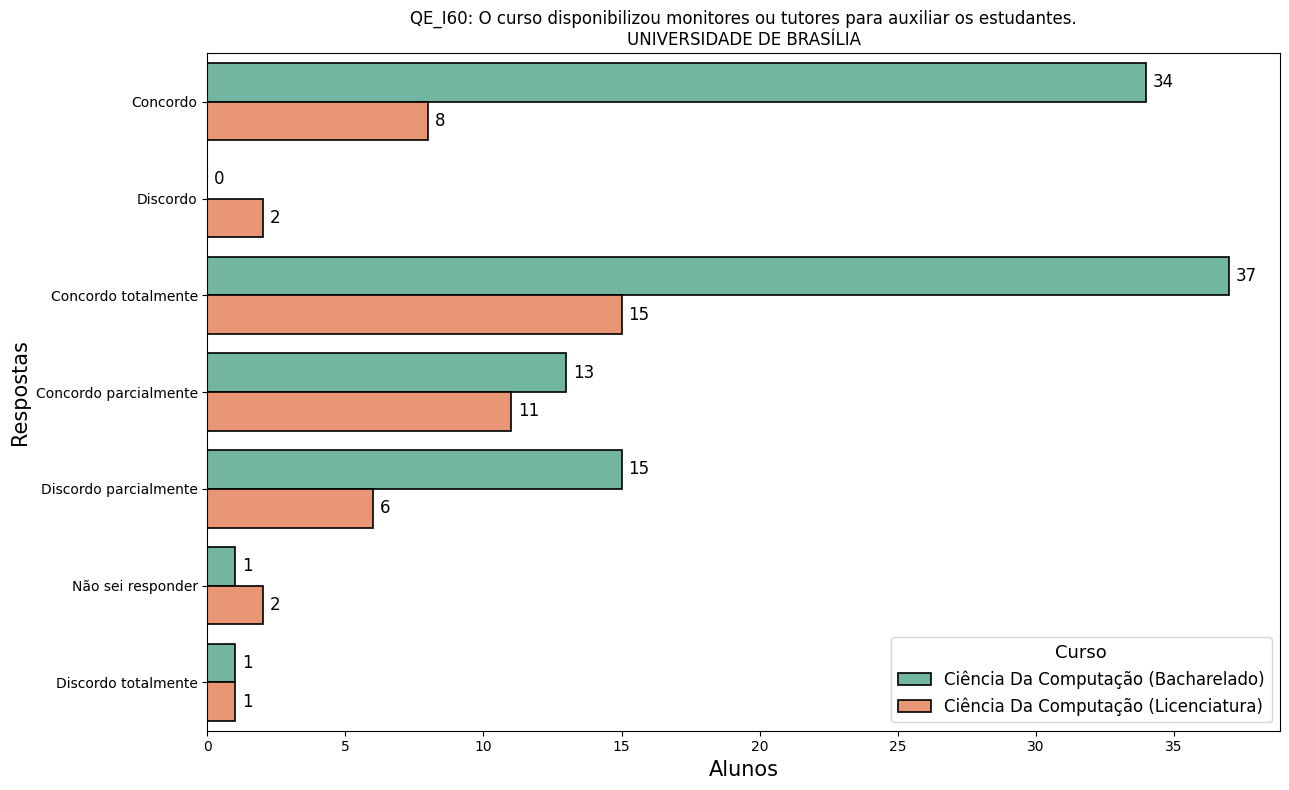

In [ ]:
qe_column = 'QE_I60'
titulo = f"{qe_column}: O curso disponibilizou monitores ou tutores para auxiliar os estudantes."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


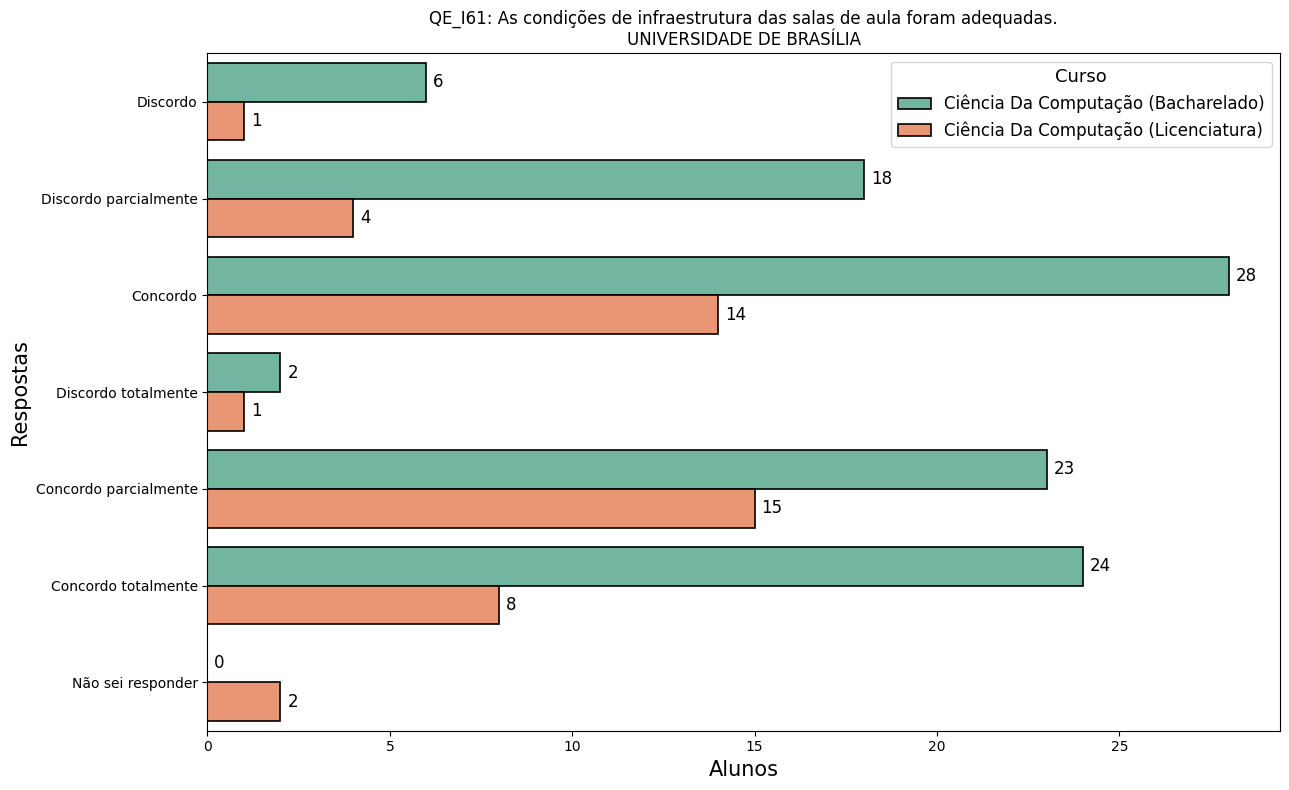

In [ ]:
qe_column = 'QE_I61'
titulo = f"{qe_column}: As condições de infraestrutura das salas de aula foram adequadas."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


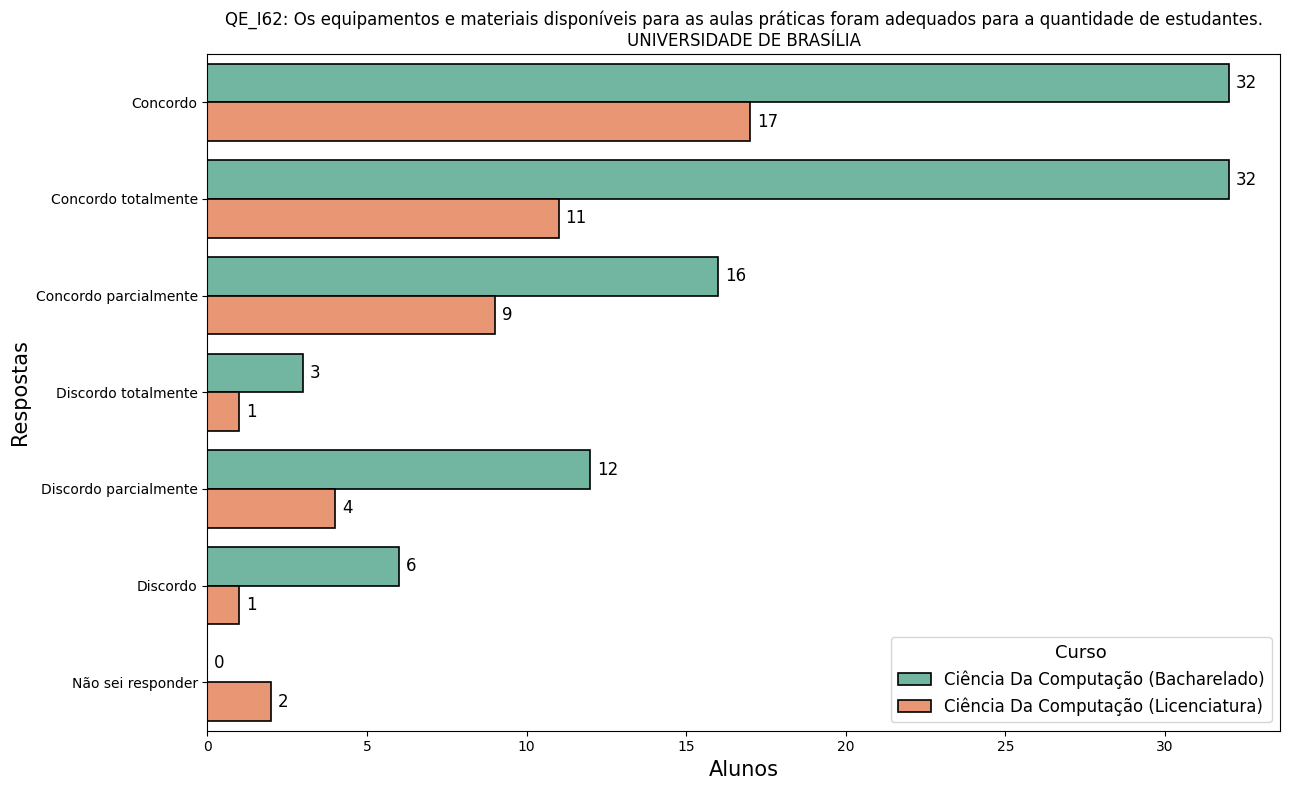

In [ ]:
qe_column = 'QE_I62'
titulo = f"{qe_column}: Os equipamentos e materiais disponíveis para as aulas práticas foram adequados para a quantidade de estudantes."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


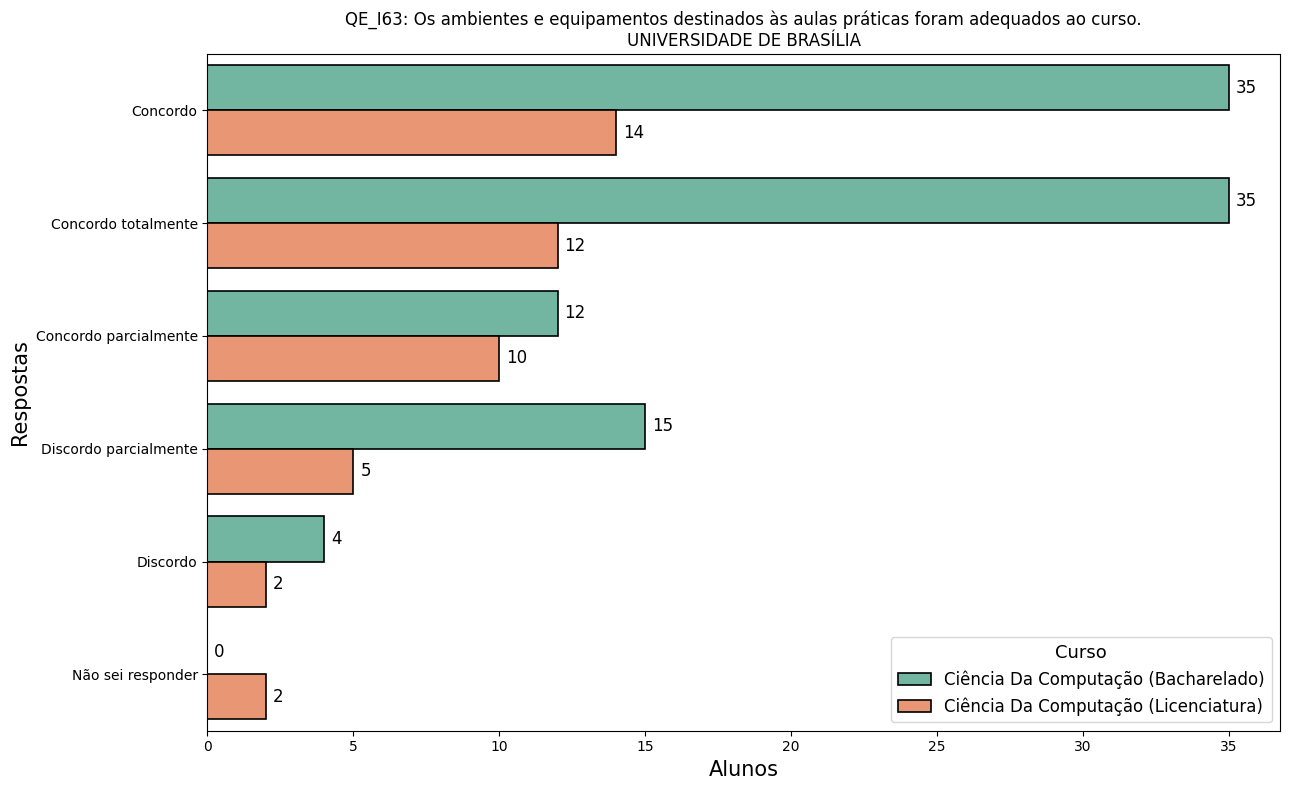

In [ ]:
qe_column = 'QE_I63'
titulo = f"{qe_column}: Os ambientes e equipamentos destinados às aulas práticas foram adequados ao curso."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


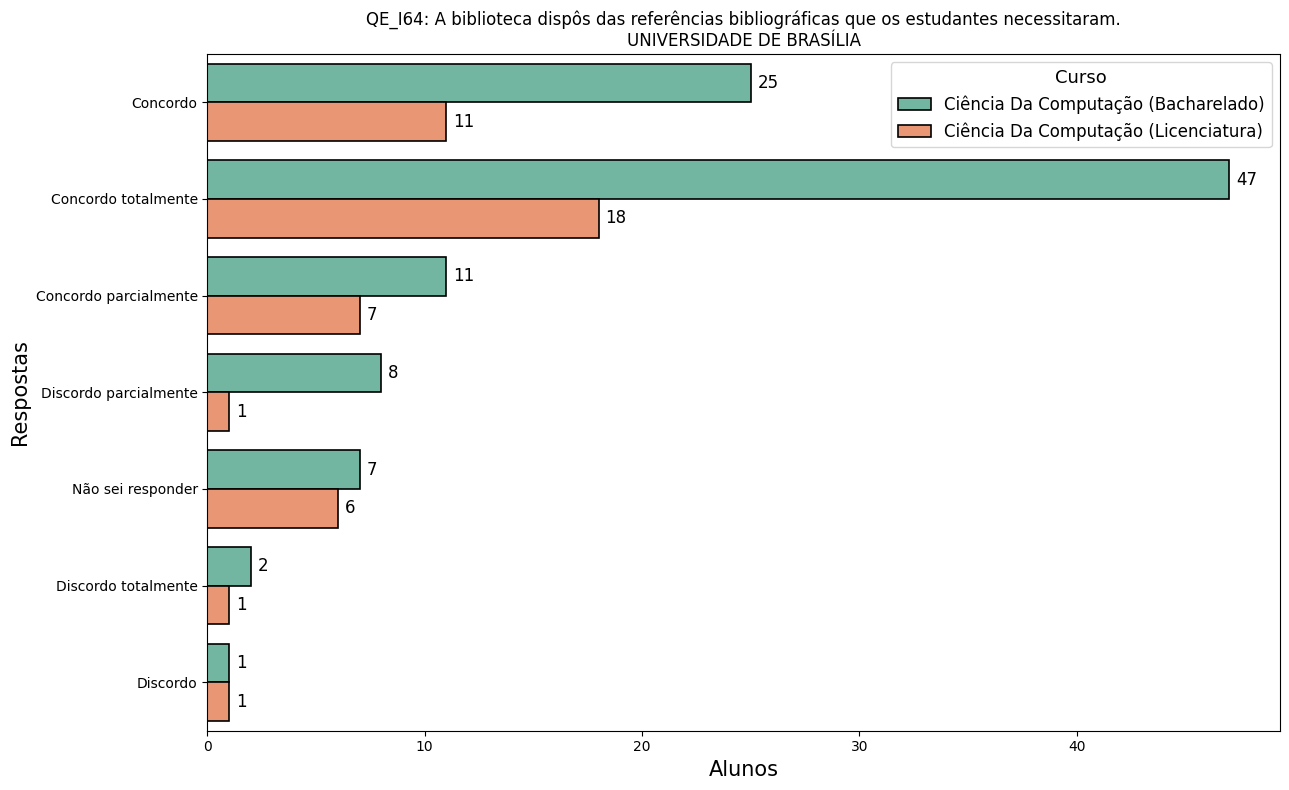

In [ ]:
qe_column = 'QE_I64'
titulo = f"{qe_column}: A biblioteca dispôs das referências bibliográficas que os estudantes necessitaram."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_dis, qe_column, titulo)


## Analisis Questoes Pandemia

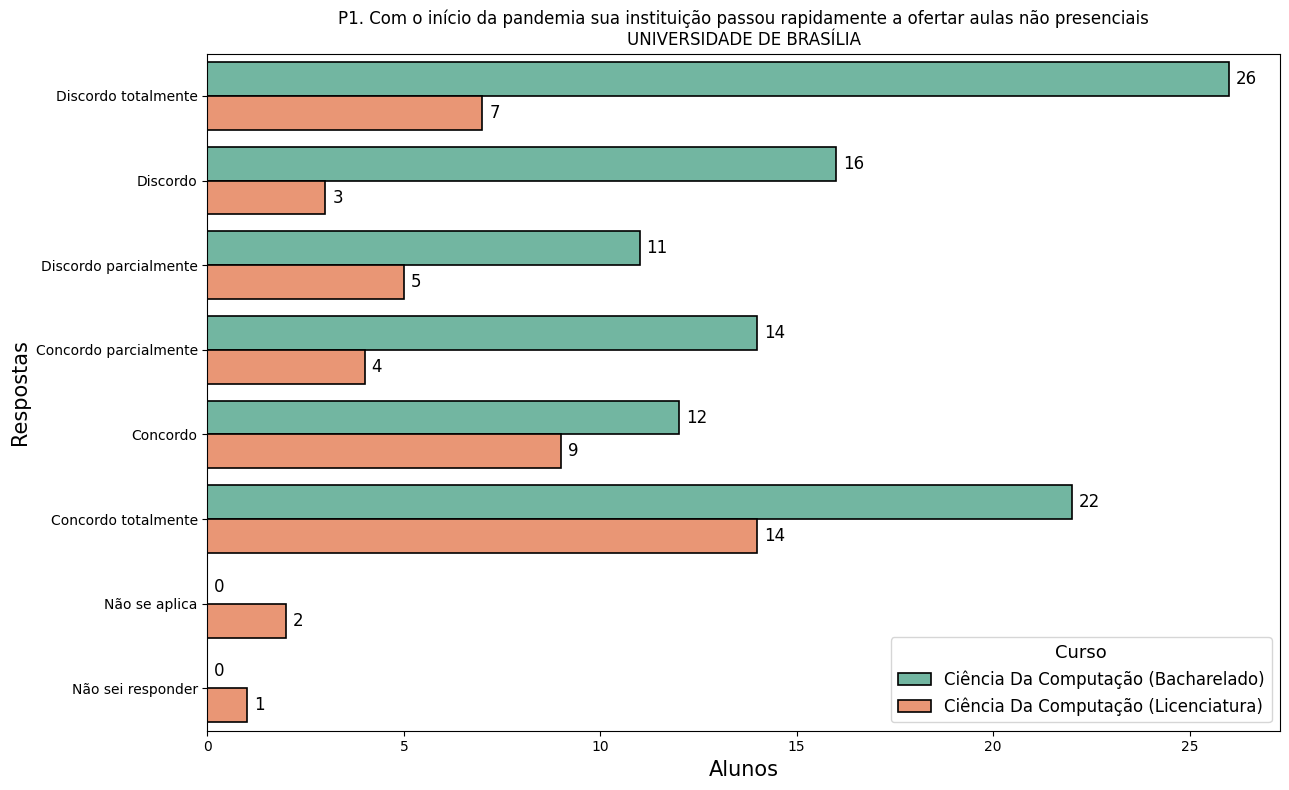

In [ ]:
dir_entrada_pandemia = 'microdados_tratados/form_microdados_arq43.csv'
qe_column = 'QE_I82'

titulo = f"P1. Com o início da pandemia sua instituição passou rapidamente a ofertar aulas não presenciais."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

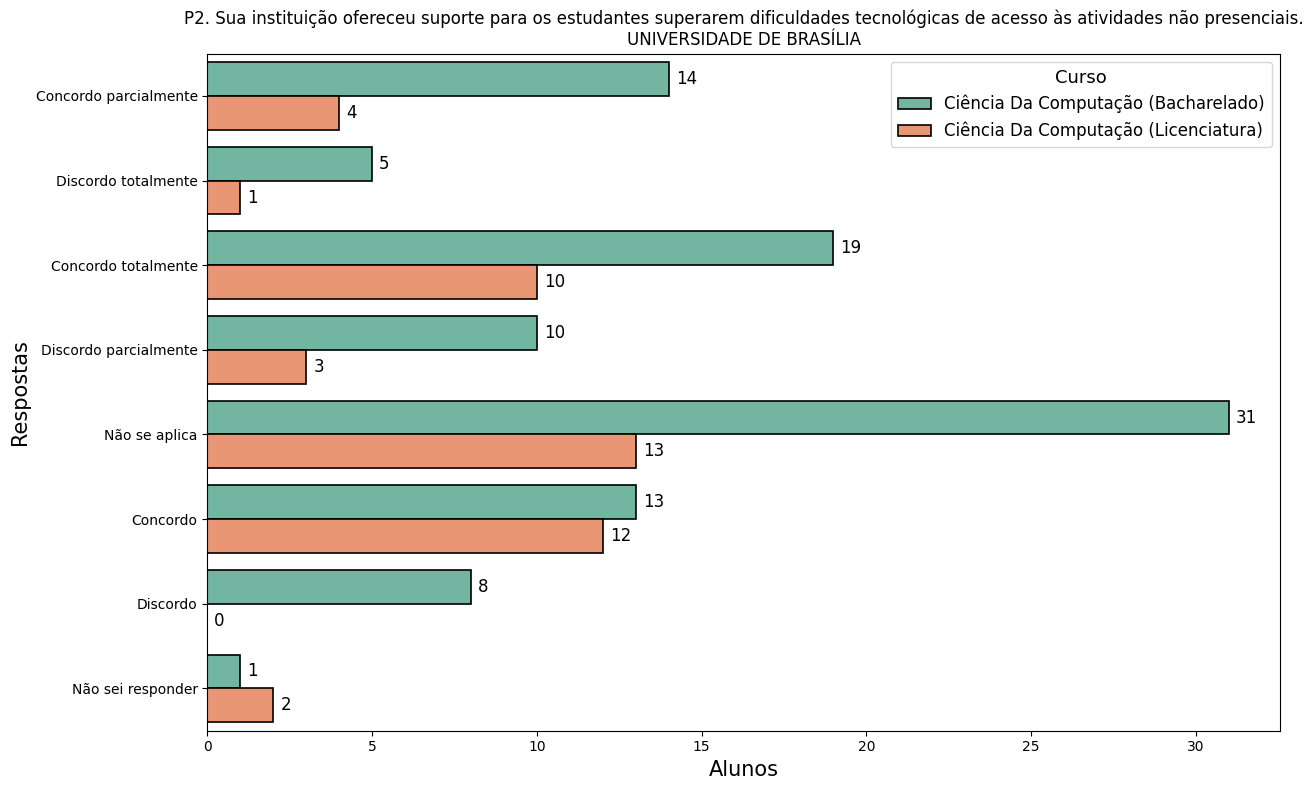

In [55]:
qe_column = 'QE_I83'
titulo = "P2. Sua instituição ofereceu suporte para os estudantes superarem dificuldades tecnológicas de acesso às atividades não presenciais."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

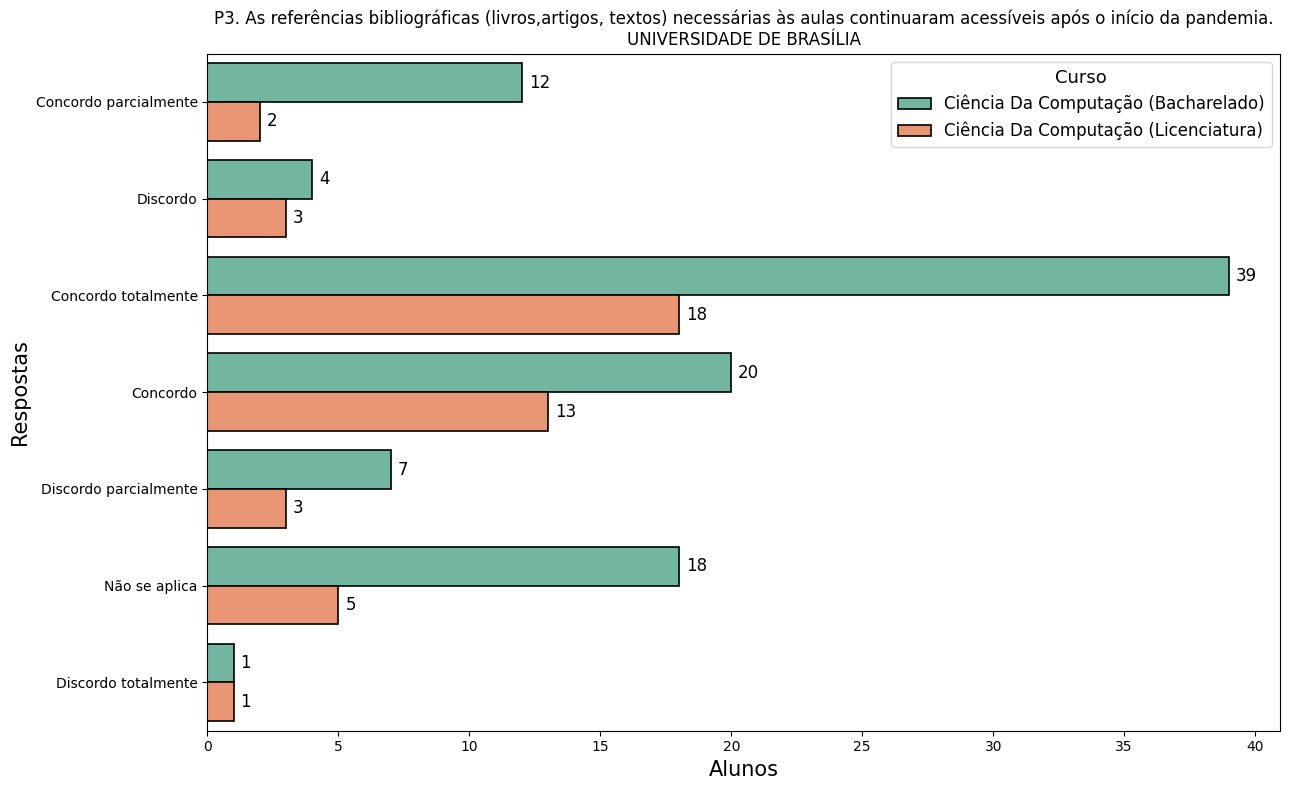

In [ ]:
qe_column = 'QE_I84'
titulo = "P3. As referências bibliográficas (livros,artigos, textos) necessárias às aulas continuaram acessíveis após o início da pandemia."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

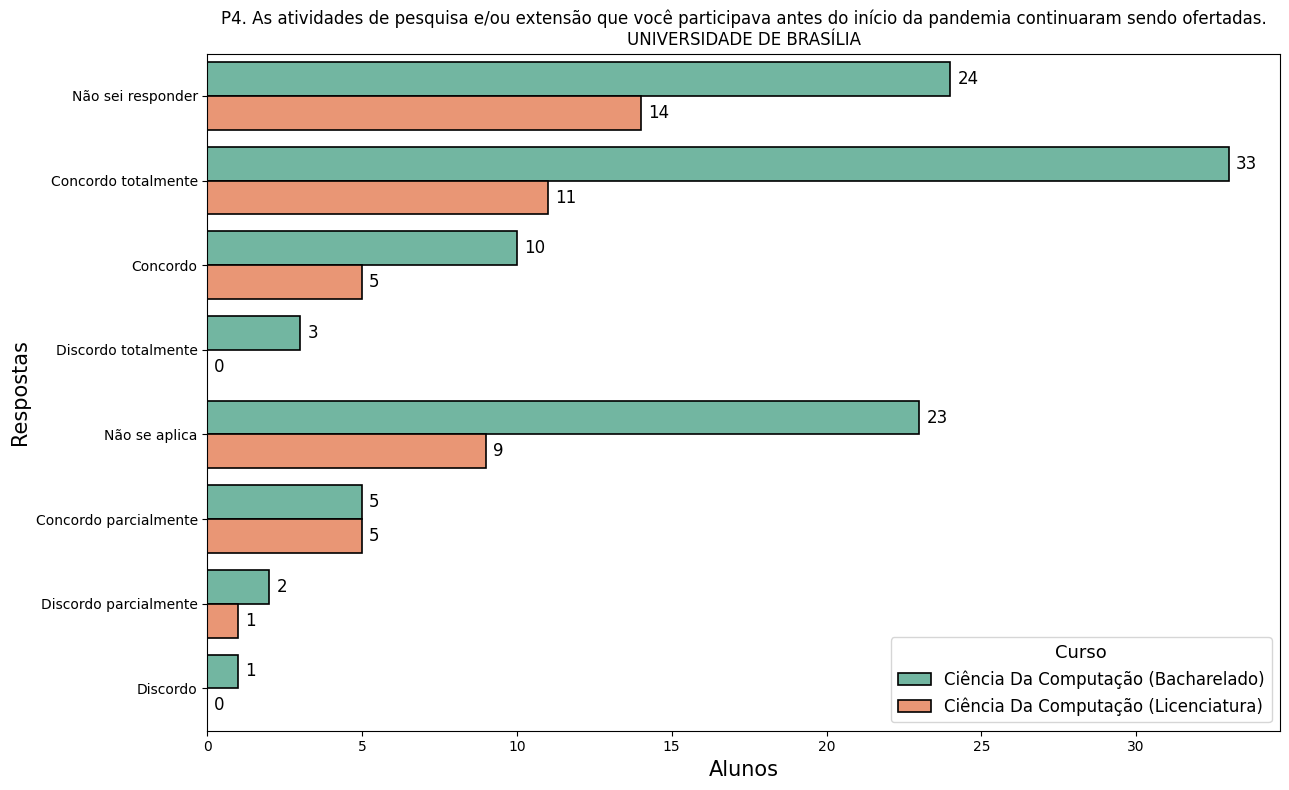

In [ ]:
qe_column = 'QE_I85'
titulo = "P4. As atividades de pesquisa e/ou extensão que você participava antes do início da pandemia continuaram sendo ofertadas."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

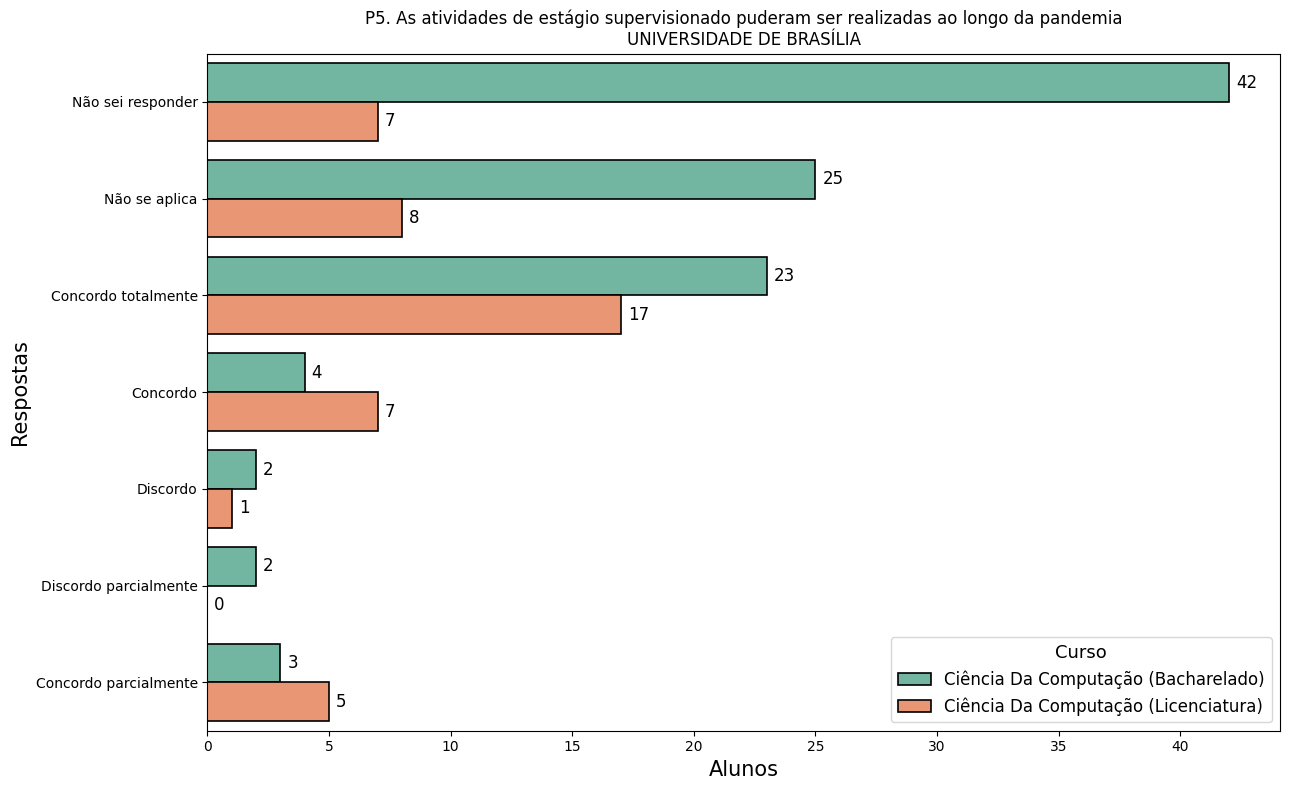

In [ ]:
qe_column = 'QE_I86'
titulo = "P5. As atividades de estágio supervisionado puderam ser realizadas ao longo da pandemia"

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

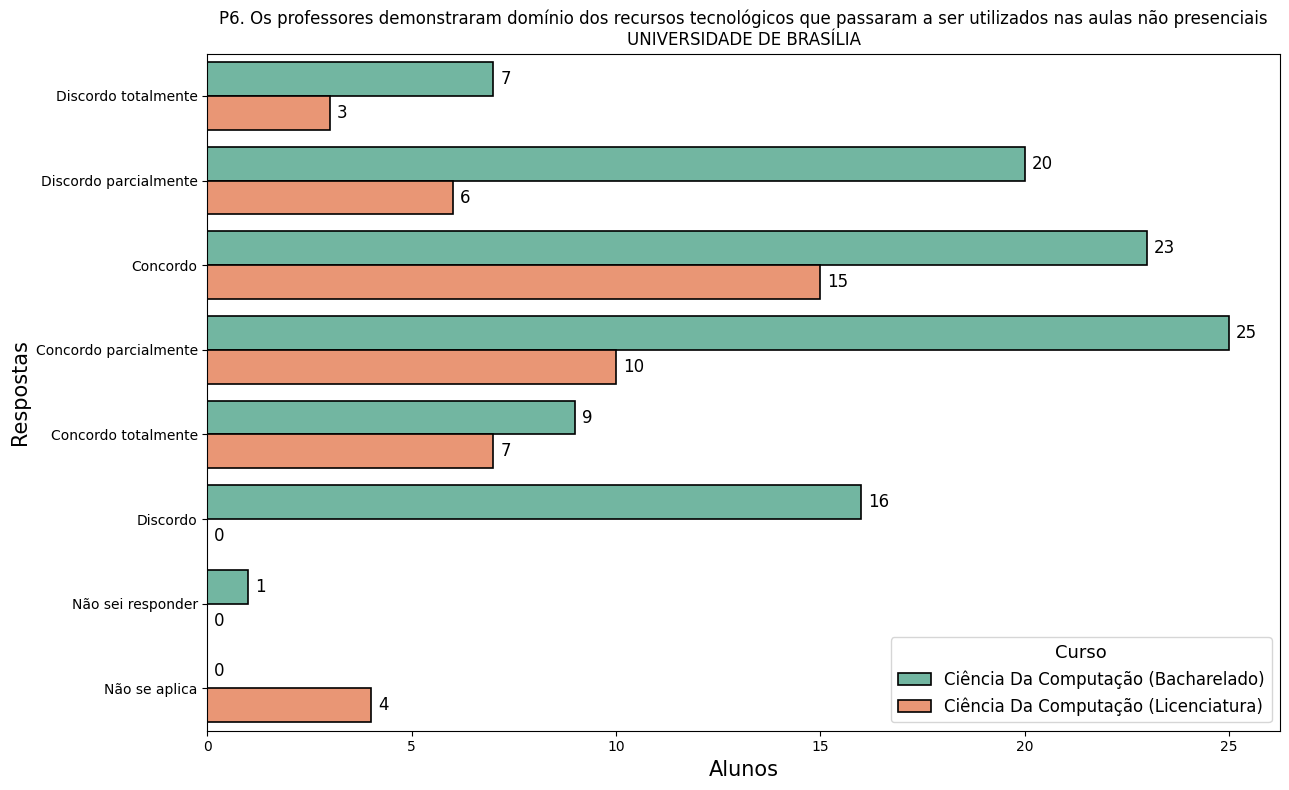

In [ ]:
qe_column = 'QE_I87'
titulo = "P6. Os professores demonstraram domínio dos recursos tecnológicos que passaram a ser utilizados nas aulas não presenciais"

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

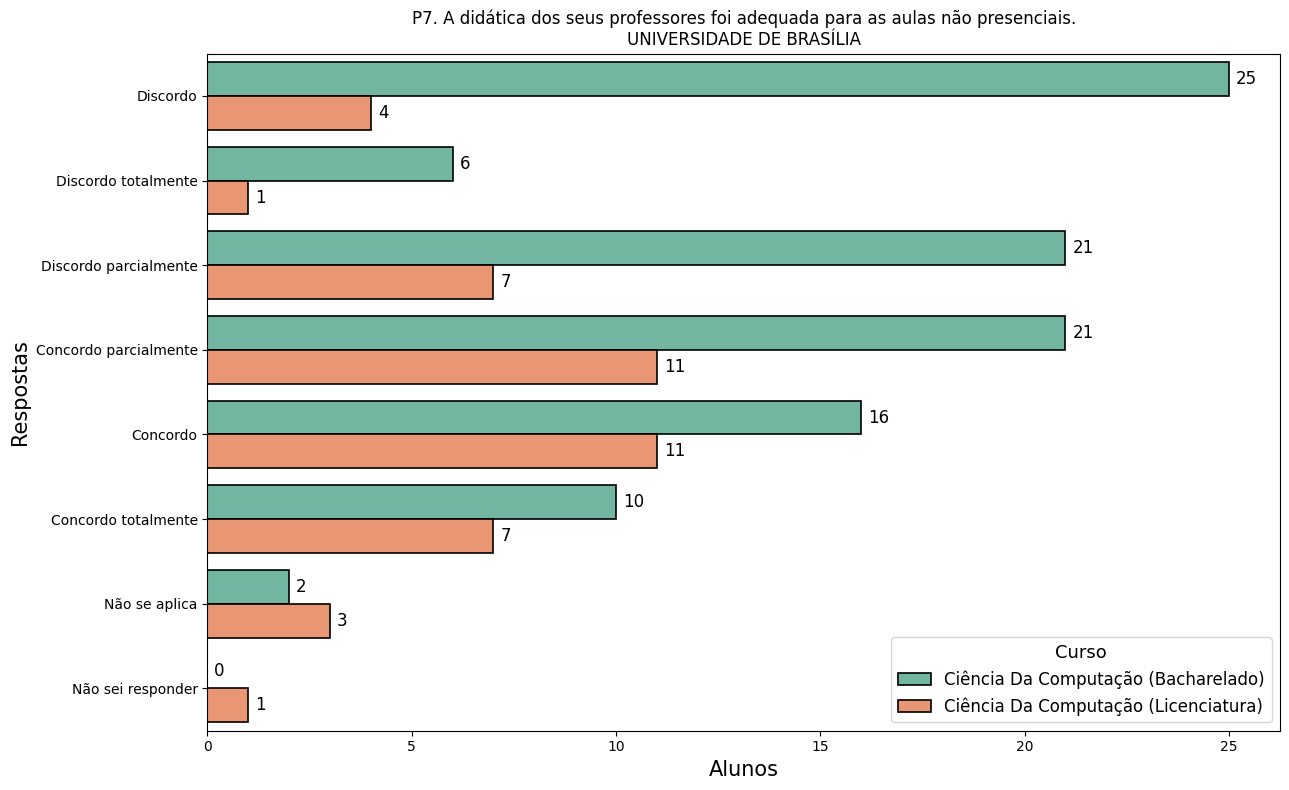

In [ ]:
qe_column = 'QE_I88'
titulo = "P7. A didática dos seus professores foi adequada para as aulas não presenciais."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

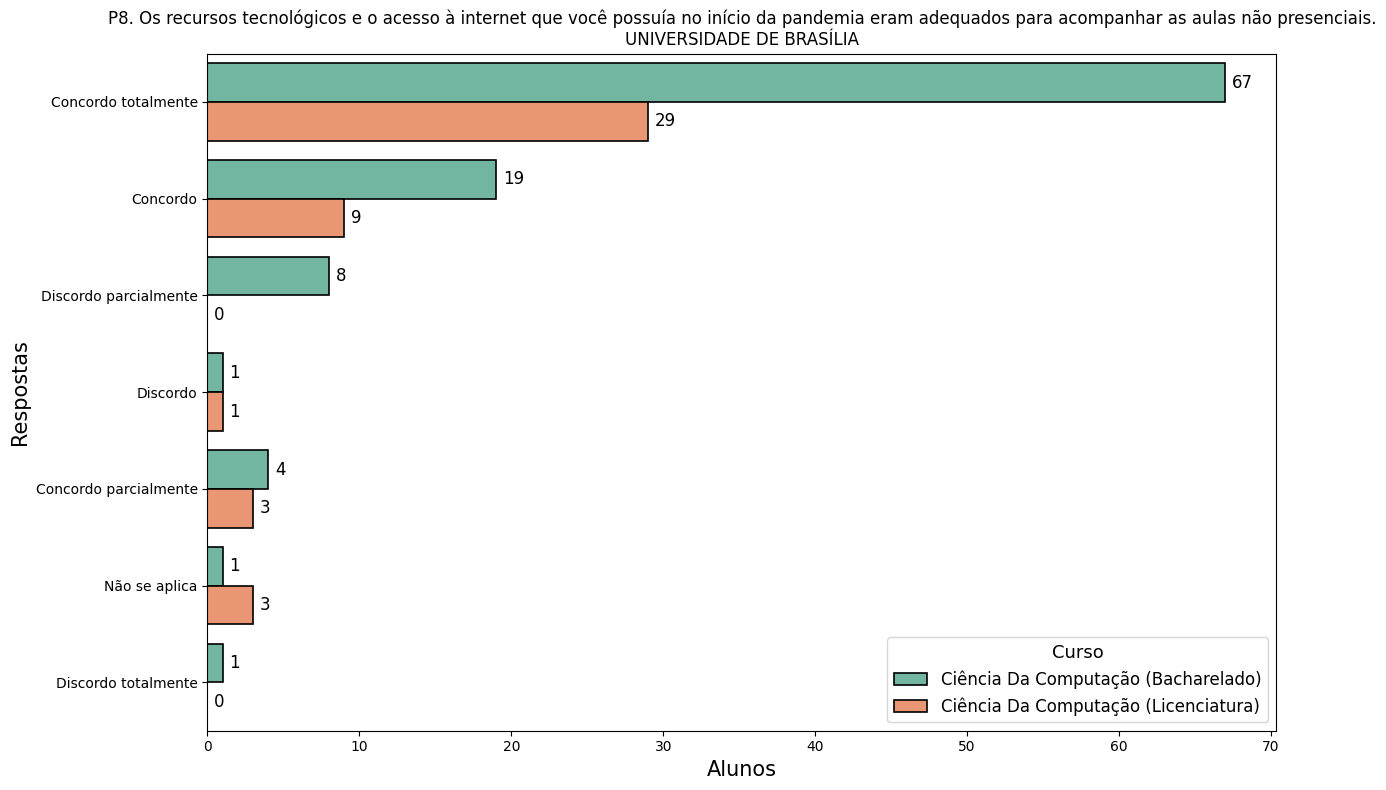

In [ ]:
qe_column = 'QE_I89'
titulo = "P8. Os recursos tecnológicos e o acesso à internet que você possuía no início da pandemia eram adequados para acompanhar as aulas não presenciais."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

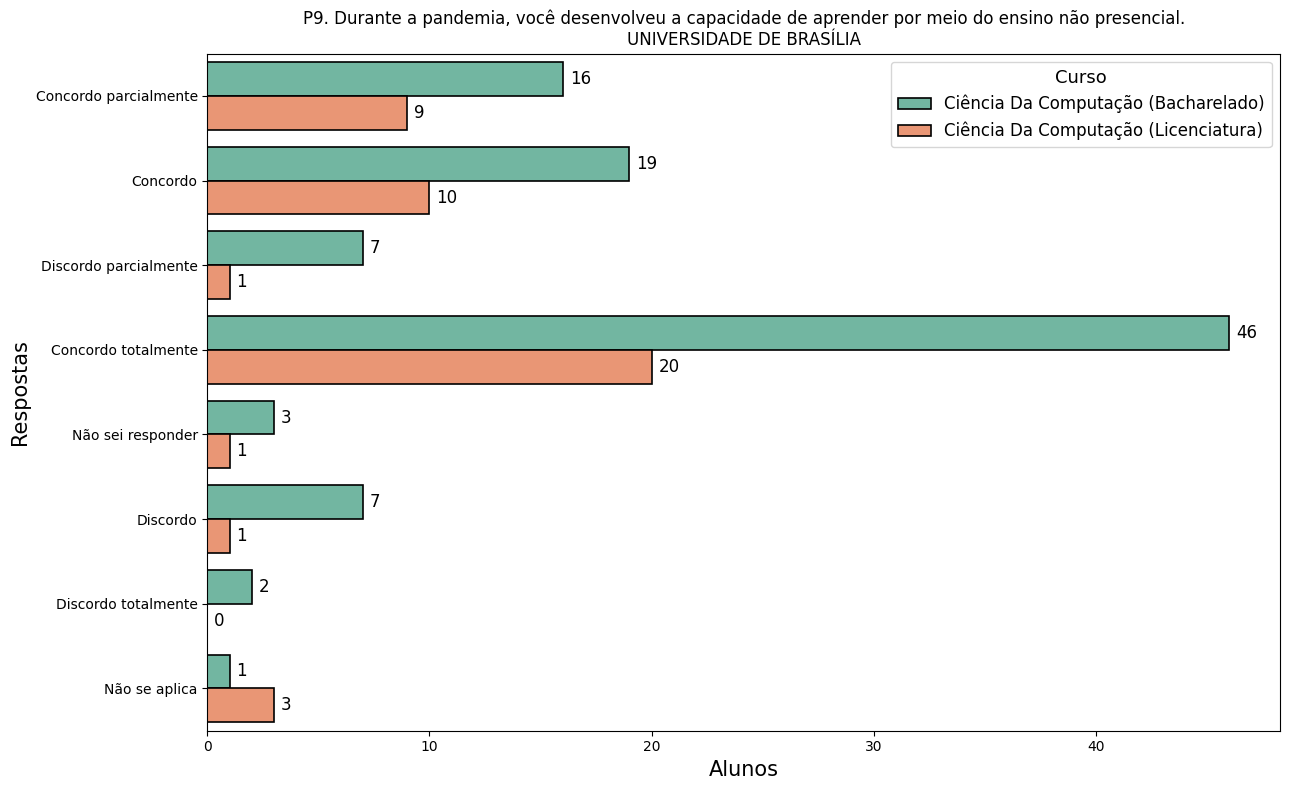

In [ ]:
qe_column = 'QE_I90'
titulo = "P9. Durante a pandemia, você desenvolveu a capacidade de aprender por meio do ensino não presencial."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

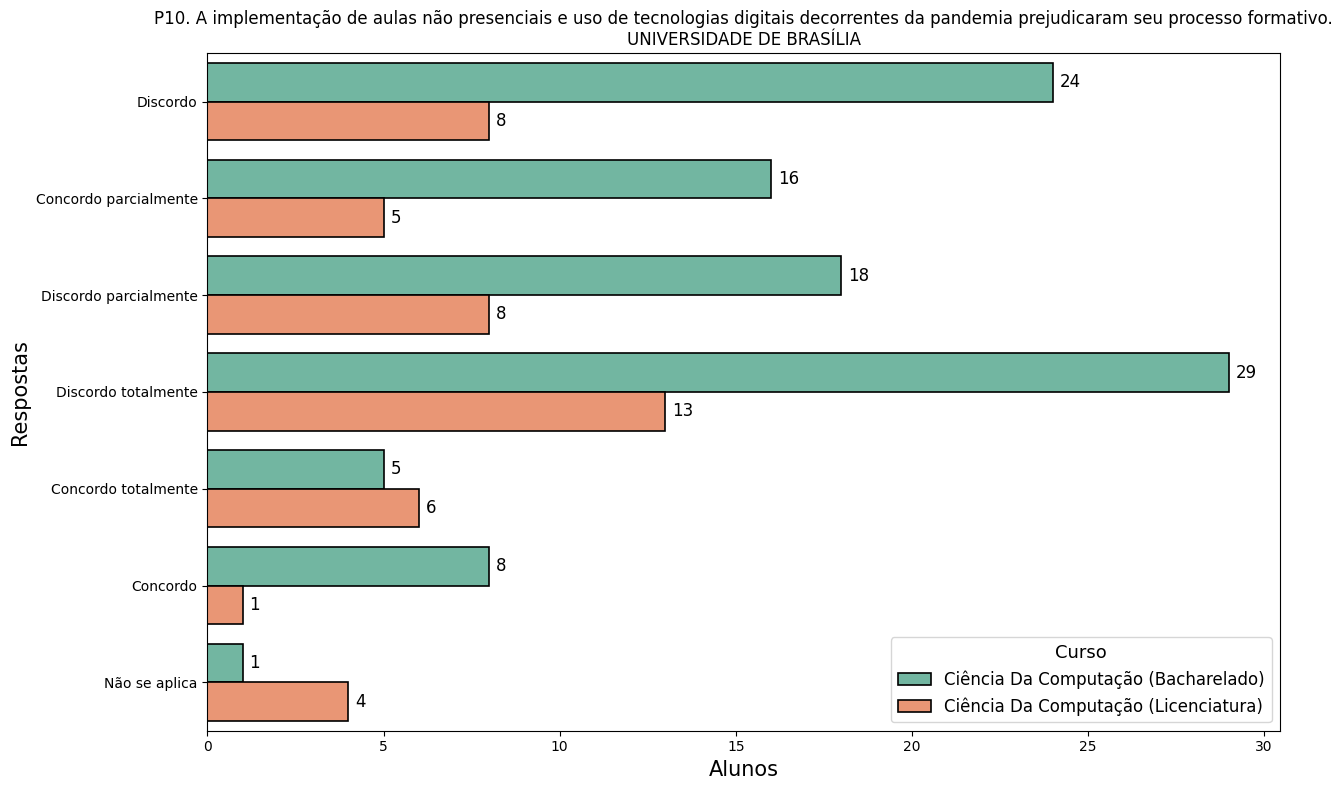

In [ ]:
qe_column = 'QE_I91'
titulo = "P10. A implementação de aulas não presenciais e uso de tecnologias digitais decorrentes da pandemia prejudicaram seu processo formativo."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)

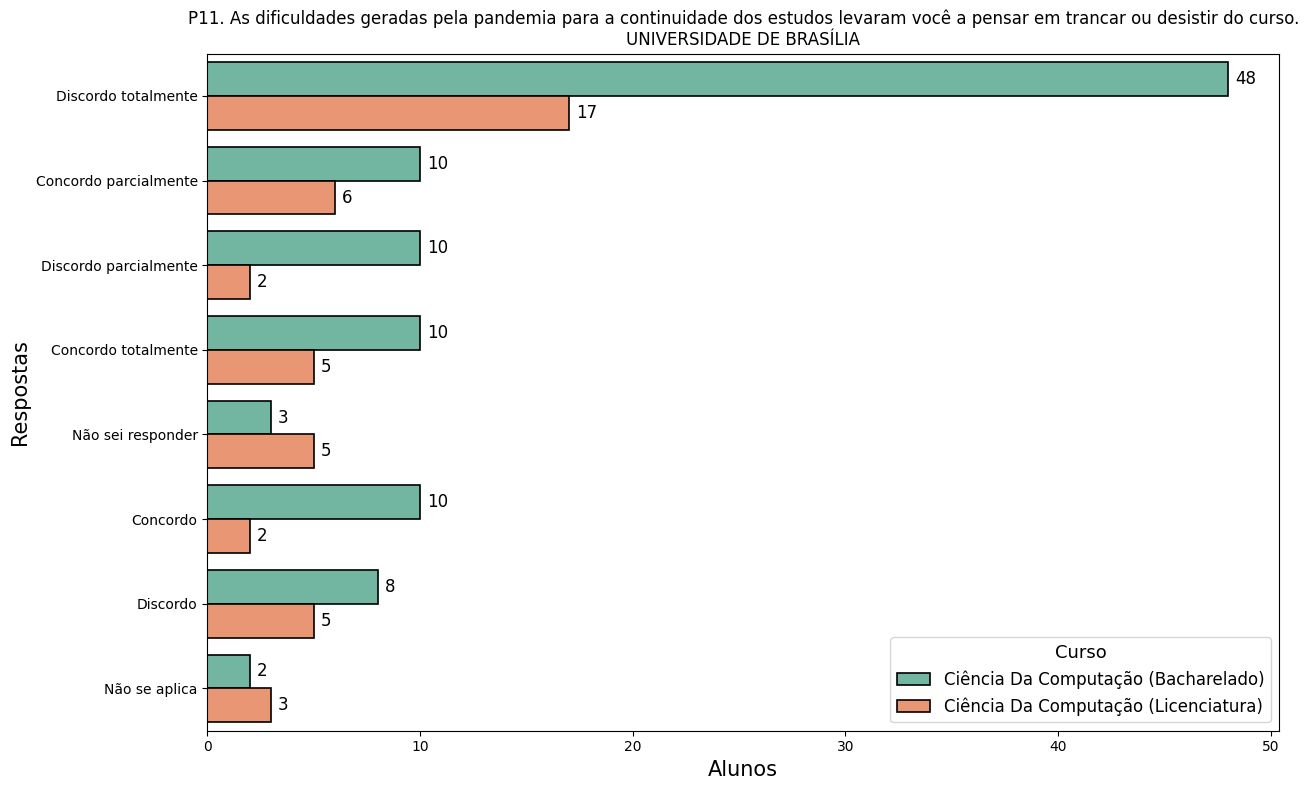

In [ ]:
qe_column = 'QE_I92'
titulo = "P11. As dificuldades geradas pela pandemia para a continuidade dos estudos levaram você a pensar em trancar ou desistir do curso."

grafico_microdados_barras_horizontal(faculdades_filtradas_CO_IES, cursos_analisados, dir_entrada_pandemia, qe_column, titulo)


## Analise QUESTIONÁRIO DE PERCEPÇÃO DA PROVA				


### Funcao grafico_percepcao_barras

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

def grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta):
    df = pd.read_csv(dir_entrada, sep=';', encoding='utf-8', low_memory=False)

    mapeamento_ies = dict(zip(df['CO_IES'], df['NOME_IES']))

    if not faculdades_filtradas_CO_IES:
        nomes_ies = ''
        df_filtrado = df.copy() 
    else:
        df_filtrado = df[df['CO_IES'].isin(faculdades_filtradas_CO_IES)].copy()  
        nomes_ies = ', '.join([mapeamento_ies.get(co_ies, 'Desconhecida') for co_ies in faculdades_filtradas_CO_IES])
        
    cursos_analisados = [unidecode(curso).lower() for curso in cursos_analisados]

    df_filtrado.loc[:, 'NOME_CURSO'] = df_filtrado['NOME_CURSO'].str.lower()
    df_filtrado = df_filtrado[df_filtrado['NOME_CURSO'].isin(cursos_analisados)]

    plt.figure(figsize=(6.5*len(cursos_analisados), 6))
    ax = sns.countplot(data=df_filtrado, y= q_percepcao, hue='NOME_CURSO', palette='Set2', edgecolor='black', linewidth=1.2)


    plt.xlabel('Alunos', fontsize=15)
    plt.ylabel('Respostas', fontsize=15)
    plt.legend(title='Curso', title_fontsize='13', fontsize='12')


    titulo = f''
    if nomes_ies:
        titulo = f'{nomes_ies}{titulo}'
    plt.title(f"{titulo_pergunta}\n{titulo}", loc='center')


    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{int(width)}',
                    (p.get_x() + width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=12, color='black', xytext=(5, 0),
                    textcoords='offset points')

   
    plt.savefig(f"{percepcao_prova}/tabela_percepcao_{q_percepcao}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


### Entrada de dados grafico_percepcao_barras

In [ ]:

faculdades_filtradas_CO_IES = [2]  
cursos_analisados = ['ciencia da computacao (licenciatura)', 'ciencia da computacao (bacharelado)']
dir_entrada = "microdados_tratados/form_microdados_arq3_percepcao_prova.csv"


### Geracao dos graficos CO_RS_I1 ate CO_RS_I9

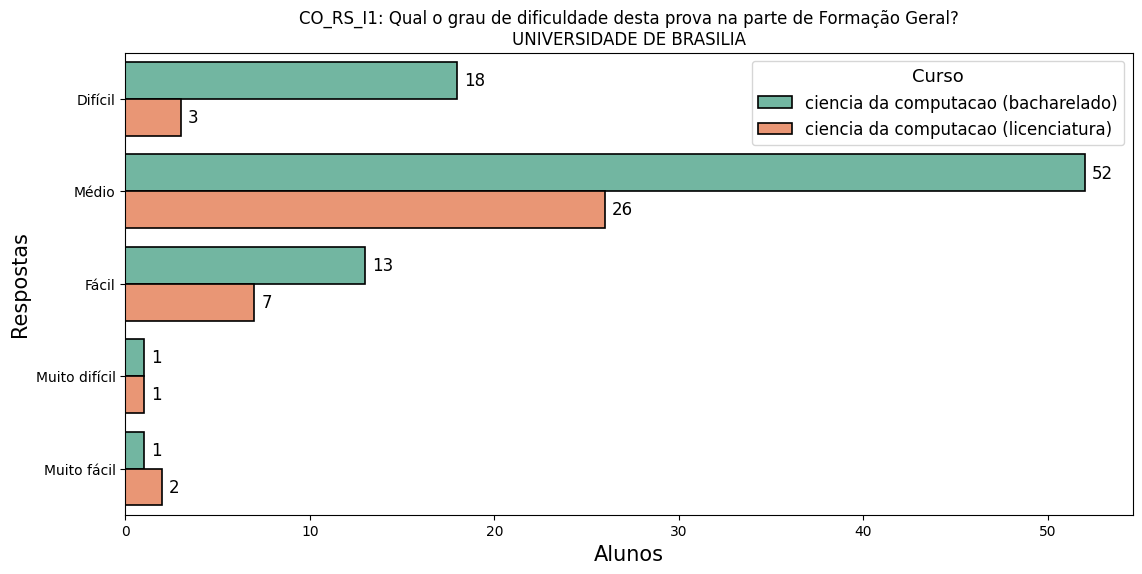

In [ ]:
q_percepcao = 'CO_RS_I1'
titulo_pergunta= f"{q_percepcao}: Qual o grau de dificuldade desta prova na parte de Formação Geral?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

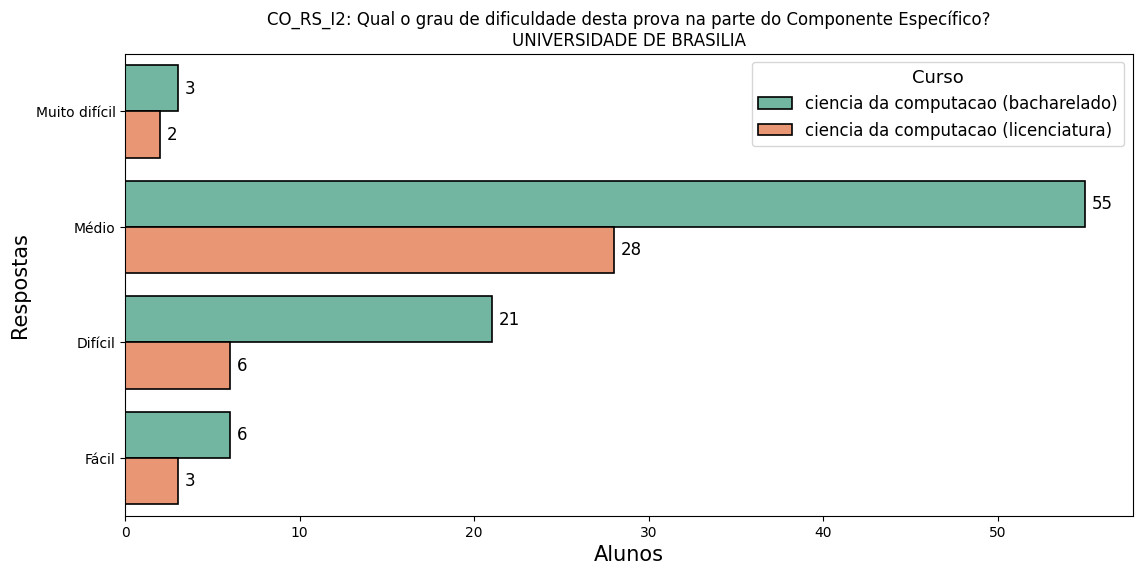

In [ ]:
q_percepcao = 'CO_RS_I2'
titulo_pergunta= f"{q_percepcao}: Qual o grau de dificuldade desta prova na parte do Componente Específico?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

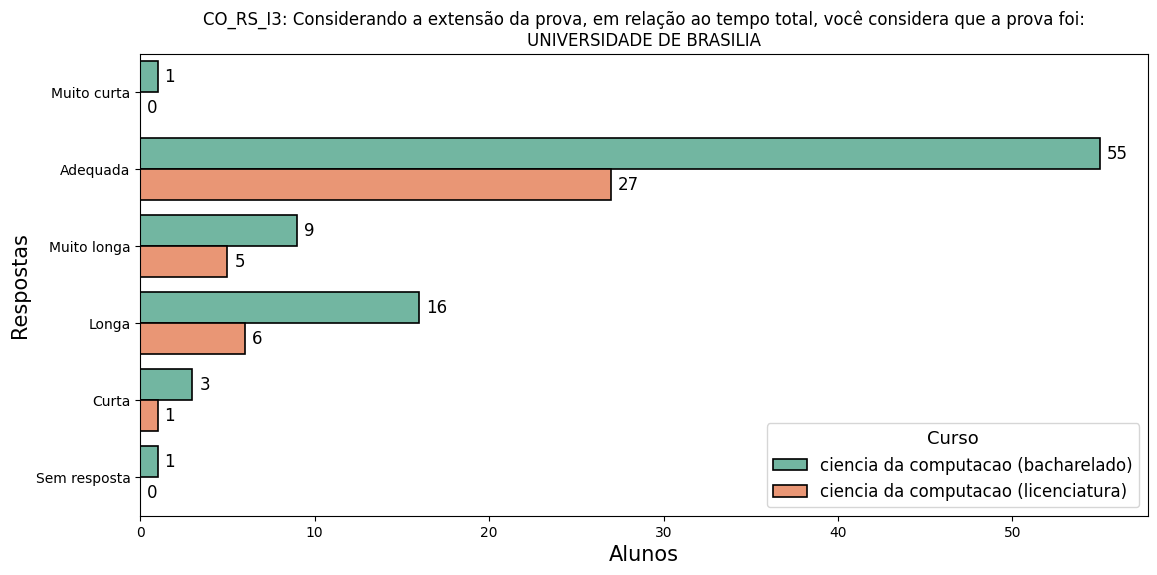

In [ ]:
q_percepcao = 'CO_RS_I3'
titulo_pergunta= f"{q_percepcao}: Considerando a extensão da prova, em relação ao tempo total, você considera que a prova foi:"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

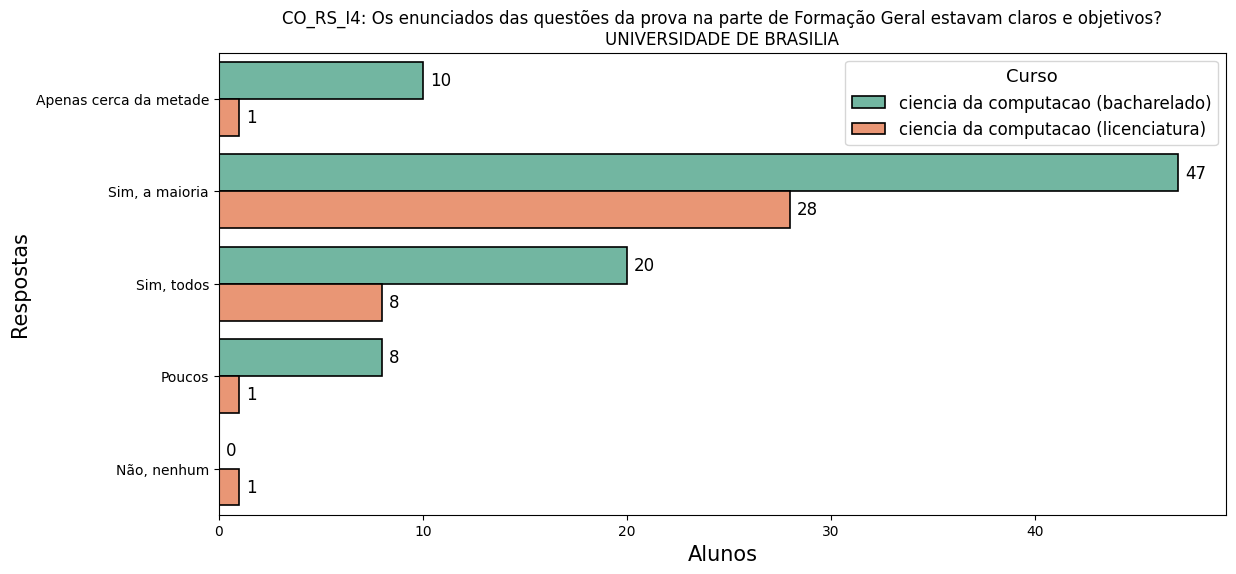

In [ ]:
q_percepcao = 'CO_RS_I4'
titulo_pergunta= f"{q_percepcao}: Os enunciados das questões da prova na parte de Formação Geral estavam claros e objetivos?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

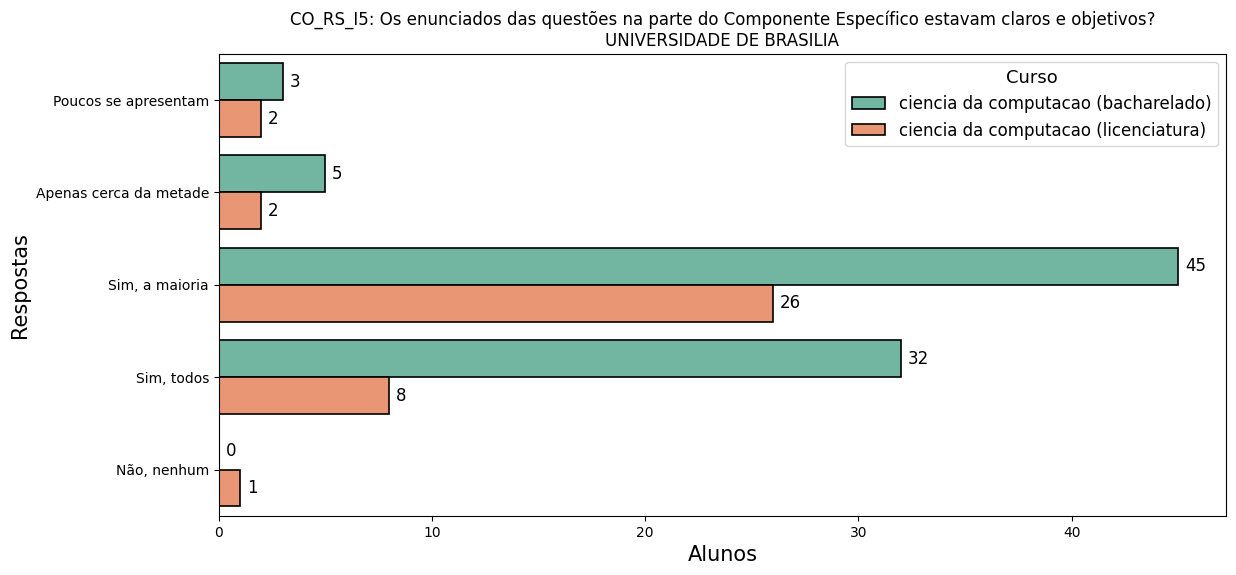

In [ ]:
q_percepcao = 'CO_RS_I5'
titulo_pergunta= f"{q_percepcao}: Os enunciados das questões na parte do Componente Específico estavam claros e objetivos?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

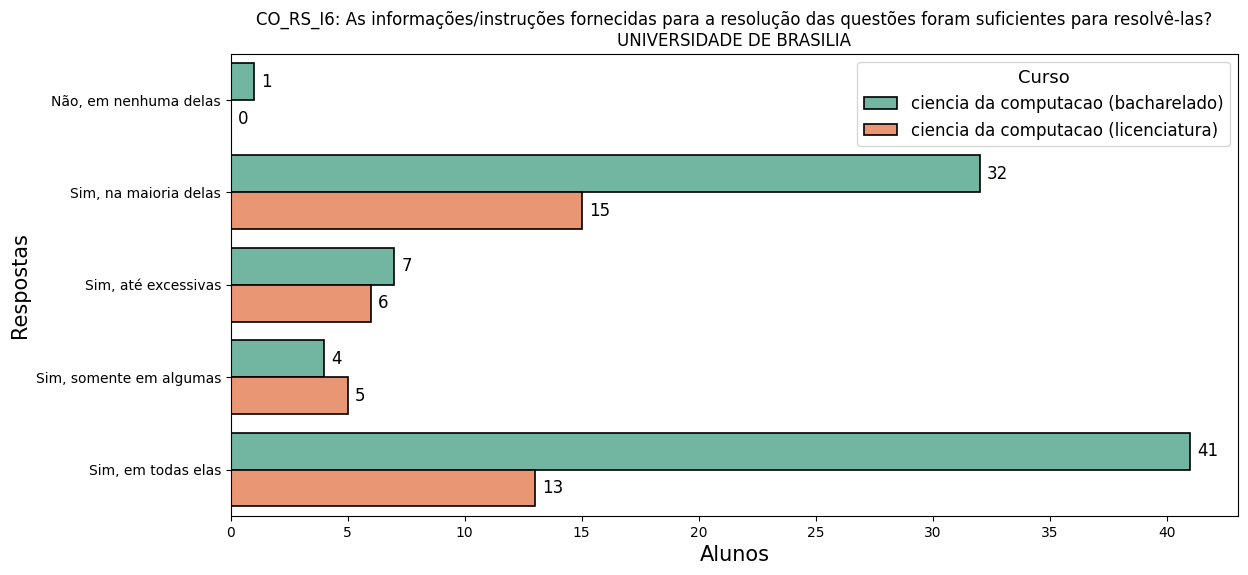

In [ ]:
q_percepcao = 'CO_RS_I6'
titulo_pergunta= f"{q_percepcao}: As informações/instruções fornecidas para a resolução das questões foram suficientes para resolvê-las?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

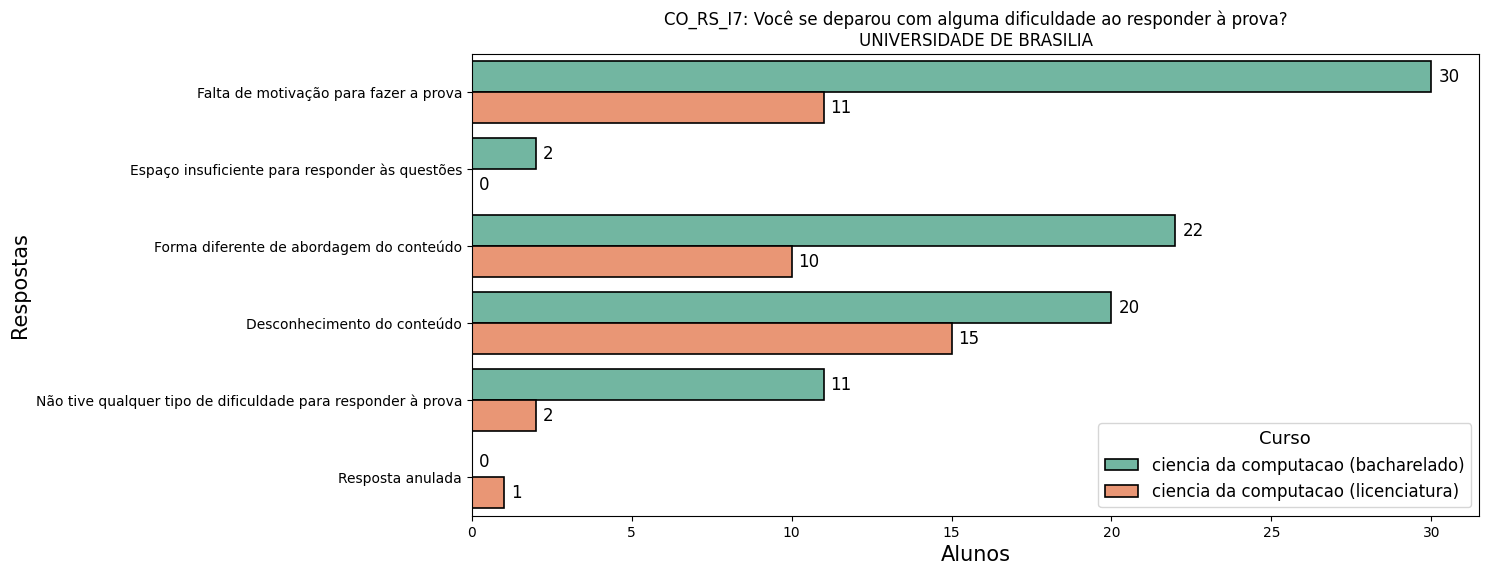

In [ ]:
q_percepcao = 'CO_RS_I7'
titulo_pergunta= f"{q_percepcao}: Você se deparou com alguma dificuldade ao responder à prova?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

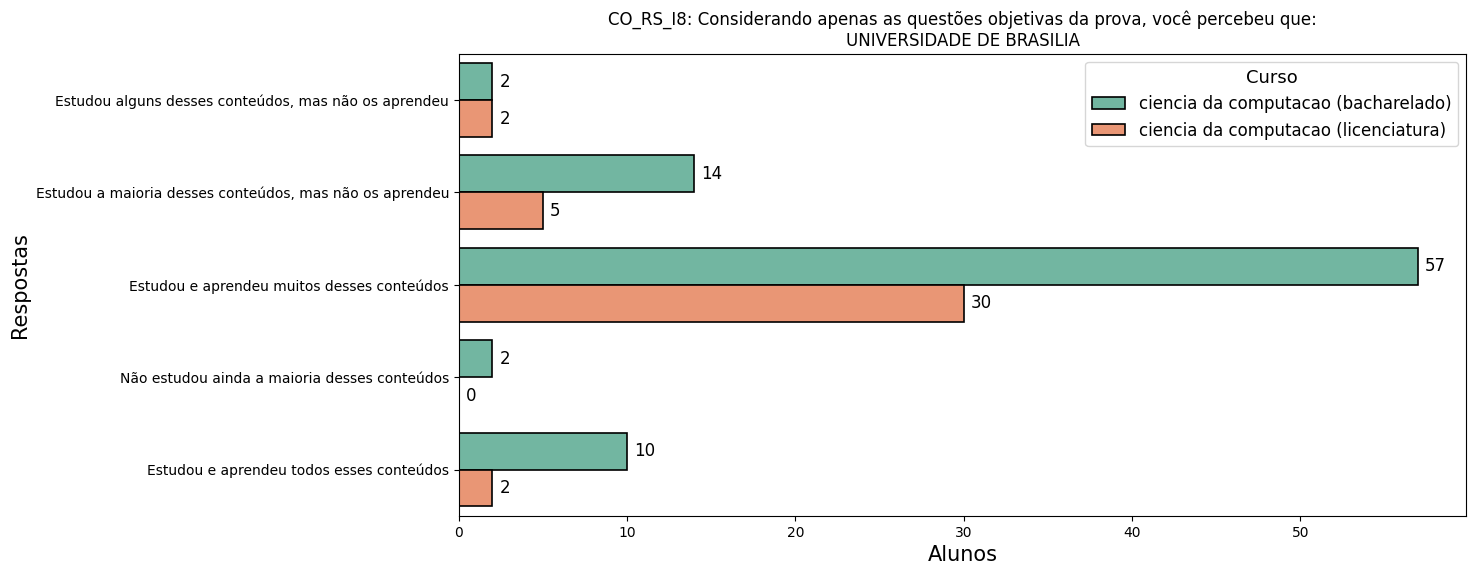

In [ ]:
q_percepcao = 'CO_RS_I8'
titulo_pergunta= f"{q_percepcao}: Considerando apenas as questões objetivas da prova, você percebeu que:"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

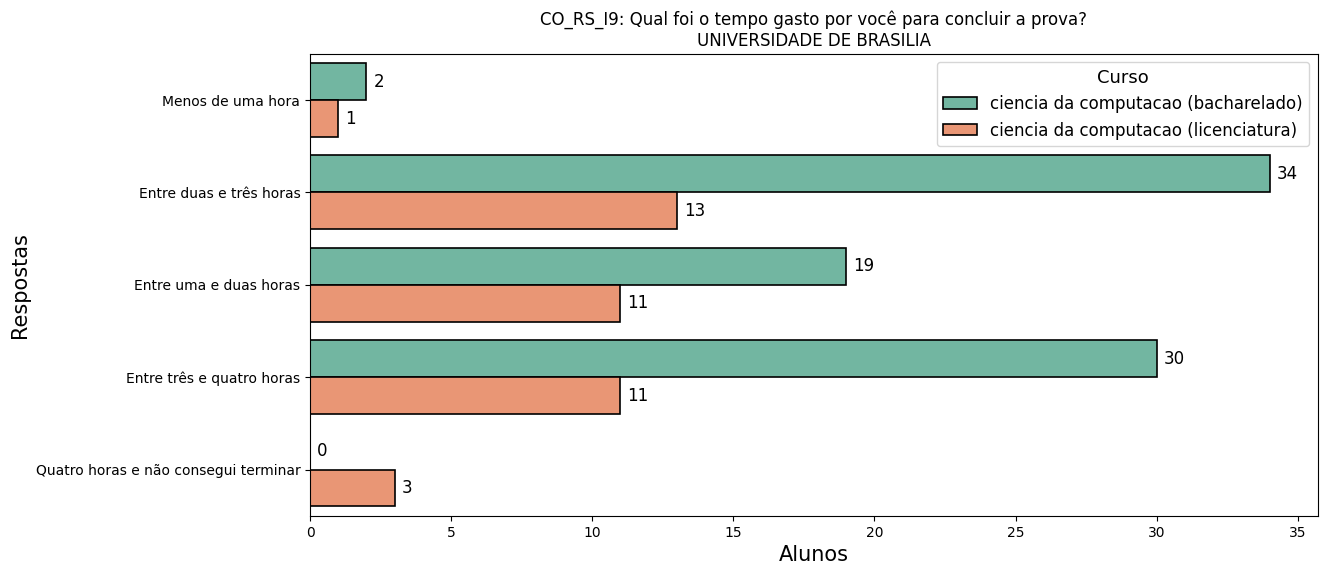

In [ ]:
q_percepcao = 'CO_RS_I9'
titulo_pergunta= f"{q_percepcao}: Qual foi o tempo gasto por você para concluir a prova?"

grafico_percepcao_barras(faculdades_filtradas_CO_IES,cursos_analisados,dir_entrada,q_percepcao,titulo_pergunta)

### Analise Componte CE


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode

def formatar_curso(course_name):
    return unidecode(course_name).lower()

def gerar_ranking_cursos(dir_entrada, cursos_analisados, faculdade_destacada):

    df = pd.read_csv(dir_entrada, sep=';', usecols=['CO_IES', 'NOME_IES', 'NOME_CURSO', 'NT_GER', 'NT_CE'])


    df['NOME_CURSO'] = df['NOME_CURSO'].apply(formatar_curso)

   
    cursos_analisados_formatados = [formatar_curso(curso) for curso in cursos_analisados]

    if cursos_analisados:
        df = df[df['NOME_CURSO'].isin(cursos_analisados_formatados)]

    df_grouped = df.groupby(['NOME_CURSO', 'NOME_IES']).agg({'NT_GER': 'mean', 'NT_CE': 'mean'}).reset_index()

    for curso in df_grouped['NOME_CURSO'].unique():
        df_curso = df_grouped[df_grouped['NOME_CURSO'] == curso].copy()
        df_curso.sort_values('NT_GER', ascending=False, inplace=True)
        df_curso['Posição no Ranking\nENADE'] = np.arange(start=1, stop=len(df_curso) + 1)  
        df_curso.sort_values('NT_CE', ascending=False, inplace=True)  
        df_curso = df_curso.head(20)  
        df_curso['Média NT_CE'] = df_curso['NT_CE'].map('{:.2f}'.format)  

    
        df_curso = df_curso[['Posição no Ranking\nENADE', 'NOME_IES', 'Média NT_CE']]
        df_curso.rename(columns={'NOME_IES': 'Faculdade'}, inplace=True)

        fig, ax = plt.subplots(figsize=(11, 8))  
        ax.axis('off')

        
        tabela = ax.table(cellText=df_curso.values, colLabels=df_curso.columns, loc='center', cellLoc='left')
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1, 1.4) 
        
        for (i, j), cell in tabela.get_celld().items():
            if i == 0:  
                cell.set_height(0.05)  
                cell.set_text_props(weight='bold', ha='center')  
            elif i > 0 and j == 1:  
                cell.set_text_props(ha='left')
            else:
                cell.set_text_props(ha='center')  

            if df_curso.iloc[i - 1]['Faculdade'] == faculdade_destacada:
                

                cell.set_facecolor('#A4FFA4')  

        
        tabela.auto_set_column_width(col=list(range(len(df_curso.columns))))
        plt.title(f"Ranking do Curso: {curso}", fontsize=16, weight='bold')
        
       
        plt.tight_layout()
        plt.savefig(f"{enade}/ranking_{curso.replace(' ', '_')}.png")
        plt.show()
        plt.close()


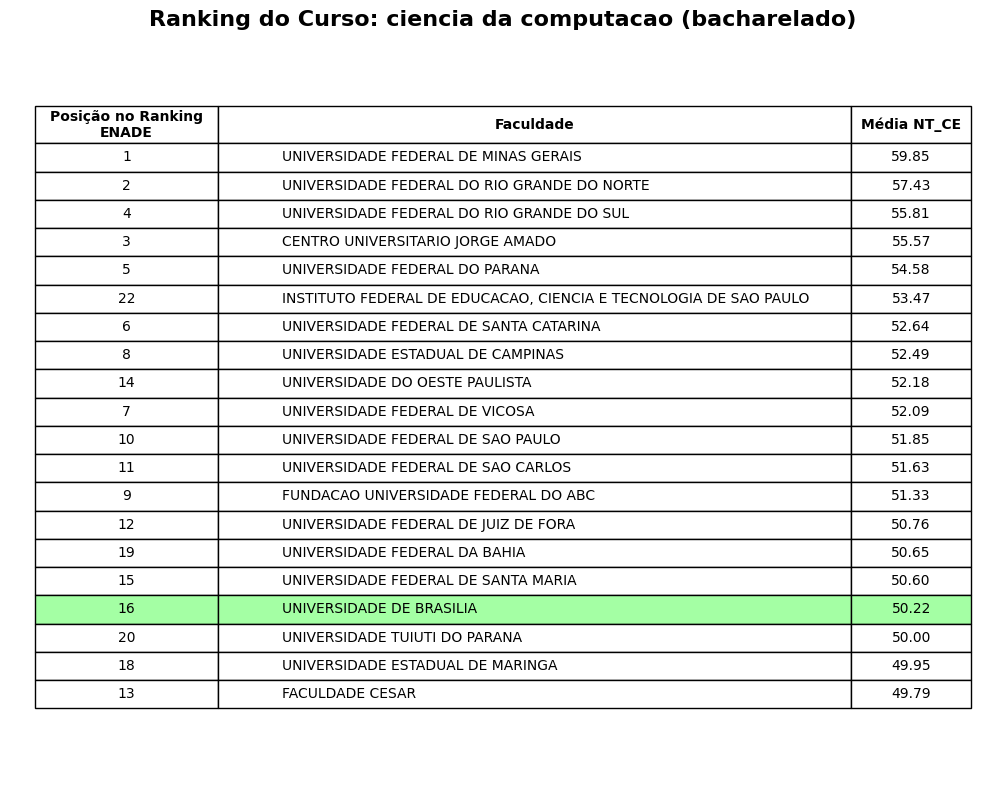

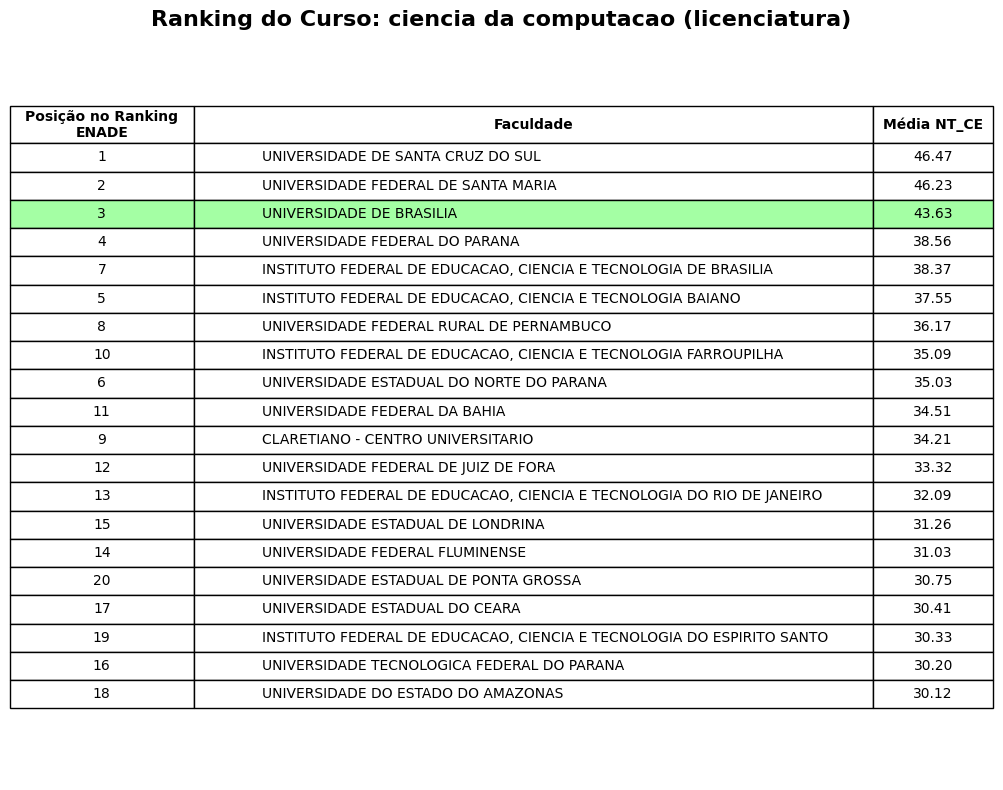

In [ ]:
cursos_analisados = [ "Ciência Da Computação (Bacharelado)" ,'ciencia da computacao (licenciatura)']

#Faculdade que vai ser destacada na tabela com a cor verde '#A4FFA4'
faculdade_destacada= 'UNIVERSIDADE DE BRASILIA'

#Arquivo de entrada
dir_entrada = 'microdados_tratados/form_microdados_arq3_vetores_filtrados.csv'

gerar_ranking_cursos(dir_entrada, cursos_analisados,faculdade_destacada)